 # Multi-Criteria Decision Analysis and Rank Prediction



 This notebook focuses on analyzing and predicting ordinal ranks that were generated from multiple decision criteria. The key goals are:



 1. **Identify key drivers** that contribute most to the rank scores

 2. **Predict future ranks** based on the order and patterns of factors

 3. **Apply proper ordinal modeling techniques** to respect the nature of the data

 4. **Handle high dimensionality** from one-hot encoding effectively

 5. **Maintain interpretability** for decision analysis

 ## 1. Import Libraries

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
import warnings
from datetime import datetime

# For preprocessing and evaluation
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectFromModel, RFE, RFECV
from sklearn.decomposition import PCA

# For ordinal regression
import mord

# For tree-based models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import lightgbm as lgbm
import xgboost as xgb

# For statistical analysis
from scipy.stats import spearmanr, kendalltau, randint, uniform

# Ignore warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12


 ## 2. Data Loading and Initial Exploration

In [2]:
def load_and_explore_data(file_path):
    """
    Load data and perform initial exploration
    
    Args:
        file_path: Path to the data file
        
    Returns:
        DataFrame with the data
    """
    print("Loading data...")
    df = pd.read_csv(file_path)
    
    # Convert date column to datetime
    df['UpdateDT'] = pd.to_datetime(df['UpdateDT'])
    
    # Sort by SubjectID and UpdateDT to ensure proper time ordering
    df = df.sort_values(['SubjectID', 'UpdateDT'])
    
    print(f"Dataset shape: {df.shape}")
    print(f"Number of unique subjects: {df['SubjectID'].nunique()}")
    print(f"Date range: {df['UpdateDT'].min()} to {df['UpdateDT'].max()}")
    
    # Check for duplicate entries
    print("\nChecking for duplicate entries...")
    original_rows = df.shape[0]
    df = df.drop_duplicates()
    exact_dupes = original_rows - df.shape[0]
    if exact_dupes > 0:
        print(f"Removed {exact_dupes} exact duplicate rows")
    else:
        print("No exact duplicates found")
    
    # Check for missing values
    missing_values = df.isnull().sum()
    if missing_values.sum() > 0:
        print("\nMissing values:")
        print(missing_values[missing_values > 0])
    else:
        print("\nNo missing values found")
    
    # Basic statistics for rank column
    print("\nRank statistics:")
    print(df['Rank'].describe())
    
    # Visualize rank distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(df['Rank'], kde=True, bins=30)
    plt.title('Distribution of Rank')
    plt.xlabel('Rank')
    plt.ylabel('Frequency')
    plt.show()
    
    # Check number of observations per subject
    subject_counts = df['SubjectID'].value_counts()
    print(f"\nObservations per subject - Min: {subject_counts.min()}, Max: {subject_counts.max()}, Avg: {subject_counts.mean():.2f}")
    
    # Visualize distribution of observations per subject
    plt.figure(figsize=(10, 6))
    sns.histplot(subject_counts, bins=30, kde=True)
    plt.title('Number of Observations per Subject')
    plt.xlabel('Number of Observations')
    plt.ylabel('Number of Subjects')
    plt.show()
    
    # Analyze update frequency
    df_sorted = df.sort_values(['SubjectID', 'UpdateDT'])
    df_sorted['TimeDiff'] = df_sorted.groupby('SubjectID')['UpdateDT'].diff()
    
    # Filter out first observation per subject (which will have NaN TimeDiff)
    time_diffs = df_sorted.dropna(subset=['TimeDiff'])['TimeDiff']
    
    print("\nTime between updates (days):")
    print(f"Min: {time_diffs.dt.days.min()}")
    print(f"Max: {time_diffs.dt.days.max()}")
    print(f"Mean: {time_diffs.dt.days.mean():.2f}")
    print(f"Median: {time_diffs.dt.days.median():.2f}")
    
    # Visualize time differences
    plt.figure(figsize=(10, 6))
    sns.histplot(time_diffs.dt.days, bins=30, kde=True)
    plt.title('Days Between Updates')
    plt.xlabel('Days')
    plt.ylabel('Frequency')
    plt.show()
    
    return df


Loading data...
Dataset shape: (31933, 20)
Number of unique subjects: 1222
Date range: 2021-05-06 14:13:00 to 2022-10-13 08:42:00

Checking for duplicate entries...
Removed 1166 exact duplicate rows

No missing values found

Rank statistics:
count    30767.000000
mean       119.788507
std         57.079803
min          1.000000
25%         77.000000
50%        118.000000
75%        160.000000
max        265.000000
Name: Rank, dtype: float64


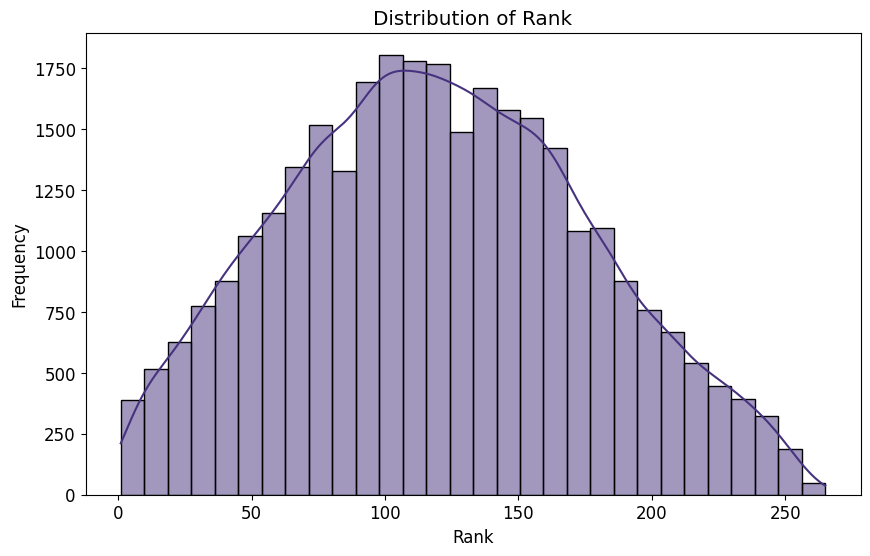


Observations per subject - Min: 1, Max: 27, Avg: 25.18


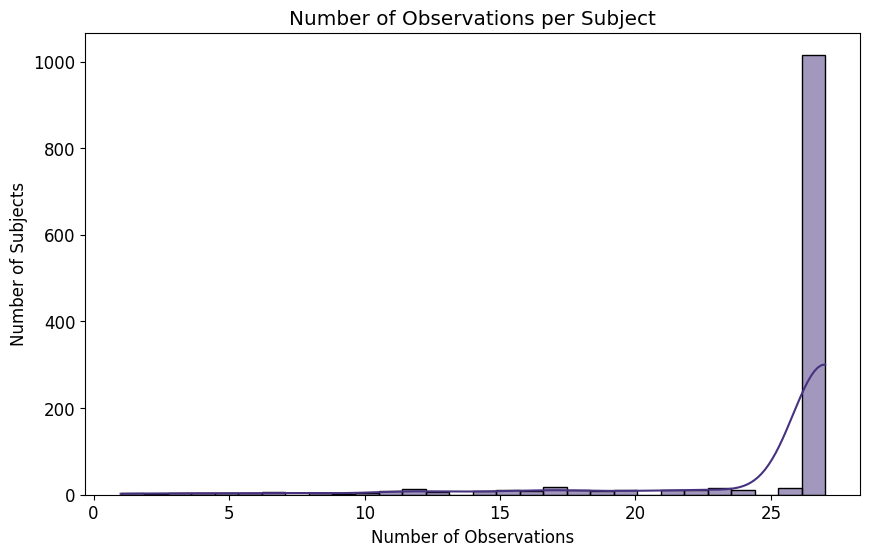


Time between updates (days):
Min: 5
Max: 477
Mean: 19.58
Median: 21.00


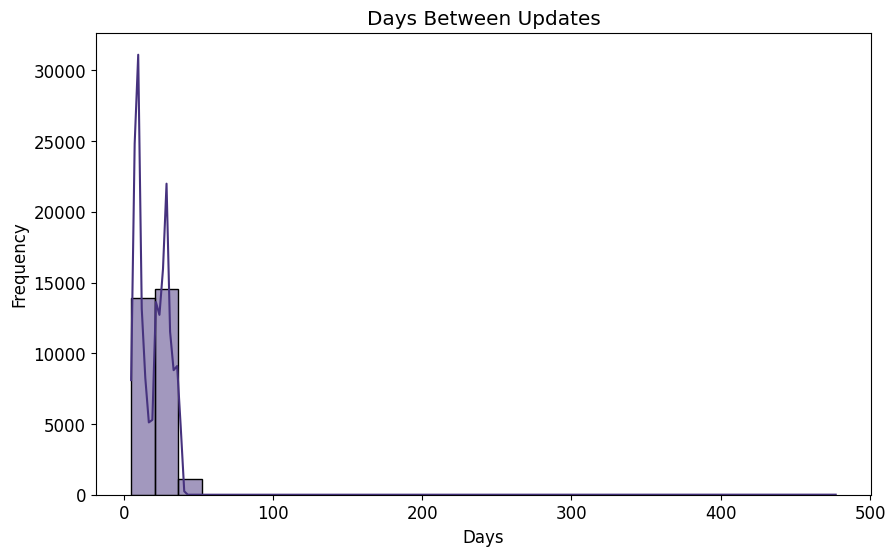

In [52]:
# Load the data
df = load_and_explore_data('Rank.csv')


 ## 3. Analyze Driver Patterns



 Let's understand the relationship between drivers and rank

In [4]:
def analyze_driver_patterns(df):
    """
    Analyze patterns in driver data and their relationship with rank
    
    Args:
        df: DataFrame with the data
        
    Returns:
        DataFrame with driver importance statistics
    """
    print("\nAnalyzing driver patterns...")
    
    # Get all driver columns
    driver_cols = [f'Driver{i}' for i in range(1, 18)]
    
    # Check unique factors in each driver column
    driver_factors = {}
    for col in driver_cols:
        unique_factors = df[col].unique()
        driver_factors[col] = unique_factors
        print(f"{col}: {len(unique_factors)} unique factors - {', '.join(unique_factors[:5])}...")
    
    # Initialize a DataFrame to store factor statistics
    factor_stats = []
    
    # For each driver and factor combination, calculate statistics
    for driver_col in driver_cols:
        for factor in df[driver_col].unique():
            # Get all rows where this driver has this factor
            factor_rows = df[df[driver_col] == factor]
            
            # Calculate average rank
            avg_rank = factor_rows['Rank'].mean()
            median_rank = factor_rows['Rank'].median()
            
            # Calculate how often this factor appears for this driver
            factor_count = len(factor_rows)
            factor_pct = factor_count / len(df) * 100
            
            # Add to statistics
            factor_stats.append({
                'Driver': driver_col,
                'Factor': factor,
                'Count': factor_count,
                'Percentage': factor_pct,
                'AvgRank': avg_rank,
                'MedianRank': median_rank
            })
    
    # Create a DataFrame
    factor_stats_df = pd.DataFrame(factor_stats)
    
    # Calculate driver importance based on rank variation
    driver_importance = factor_stats_df.groupby('Driver')['AvgRank'].agg(['std', 'count']).reset_index()
    driver_importance.columns = ['Driver', 'RankStdDev', 'FactorCount']
    
    # Higher std dev means the driver has a stronger impact on rank variation
    driver_importance = driver_importance.sort_values('RankStdDev', ascending=False)
    
    print("\nDriver importance based on rank variation:")
    print(driver_importance)
    
    # Visualize driver importance
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Driver', y='RankStdDev', data=driver_importance)
    plt.title('Driver Importance Based on Rank Variation')
    plt.xlabel('Driver')
    plt.ylabel('Standard Deviation of Rank')
    plt.xticks(rotation=45)
    plt.show()
    
    # For the top drivers, visualize the impact of different factors
    top_drivers = driver_importance.head(5)['Driver'].tolist()
    
    for driver in top_drivers:
        driver_data = factor_stats_df[factor_stats_df['Driver'] == driver].sort_values('AvgRank')
        
        plt.figure(figsize=(12, 6))
        sns.barplot(x='Factor', y='AvgRank', data=driver_data)
        plt.title(f'Average Rank by Factor for {driver}')
        plt.xlabel('Factor')
        plt.ylabel('Average Rank')
        plt.xticks(rotation=90)
        plt.show()
    
    return factor_stats_df, driver_importance



Analyzing driver patterns...
Driver1: 17 unique factors - Factor6, Factor7, Factor11, Factor17, Factor16...
Driver2: 17 unique factors - Factor14, Factor7, Factor6, Factor11, Factor16...
Driver3: 17 unique factors - Factor7, Factor16, Factor1, Factor13, Factor6...
Driver4: 17 unique factors - Factor16, Factor14, Factor7, Factor12, Factor1...
Driver5: 17 unique factors - Factor1, Factor13, Factor14, Factor12, Factor10...
Driver6: 17 unique factors - Factor13, Factor12, Factor17, Factor16, Factor1...
Driver7: 17 unique factors - Factor11, Factor17, Factor12, Factor15, Factor14...
Driver8: 17 unique factors - Factor10, Factor13, Factor17, Factor16, Factor11...
Driver9: 17 unique factors - Factor15, Factor11, Factor13, Factor17, Factor16...
Driver10: 17 unique factors - Factor12, Factor9, Factor13, Factor10, Factor15...
Driver11: 17 unique factors - Factor17, Factor15, Factor12, Factor9, Factor14...
Driver12: 17 unique factors - Factor9, Factor8, Factor10, Factor11, Factor1...
Driver13: 1

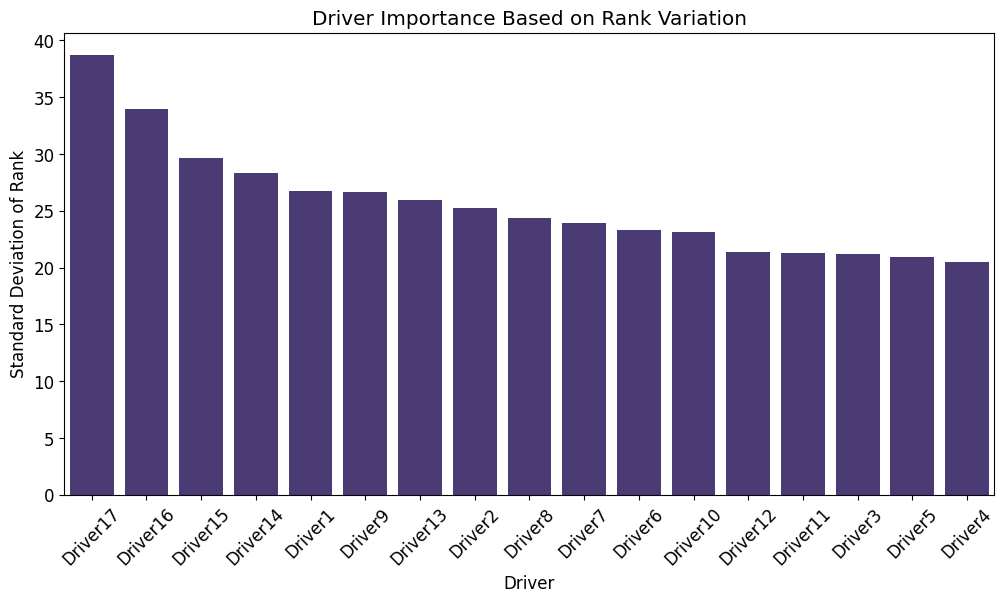

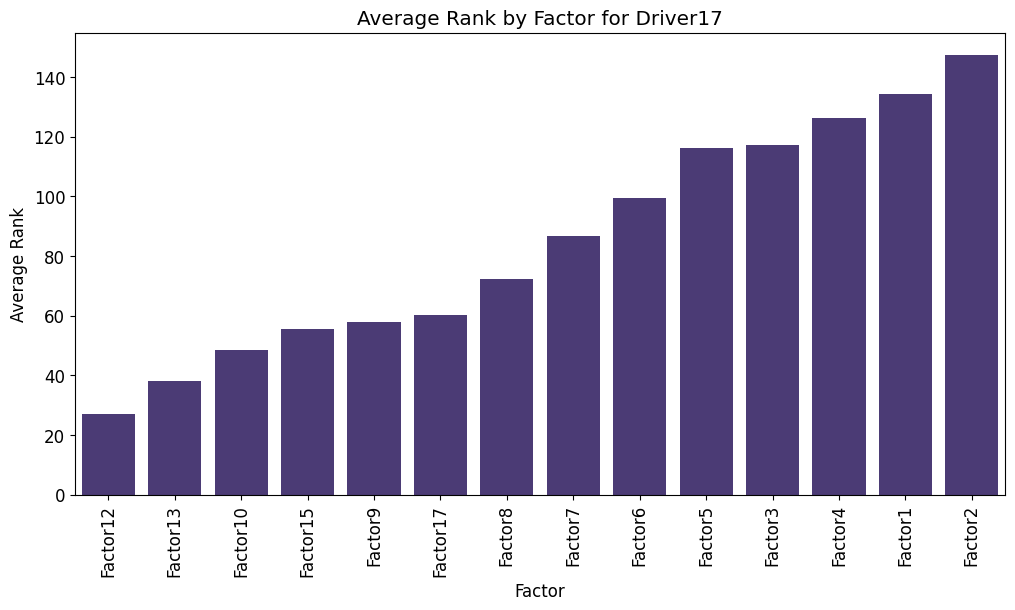

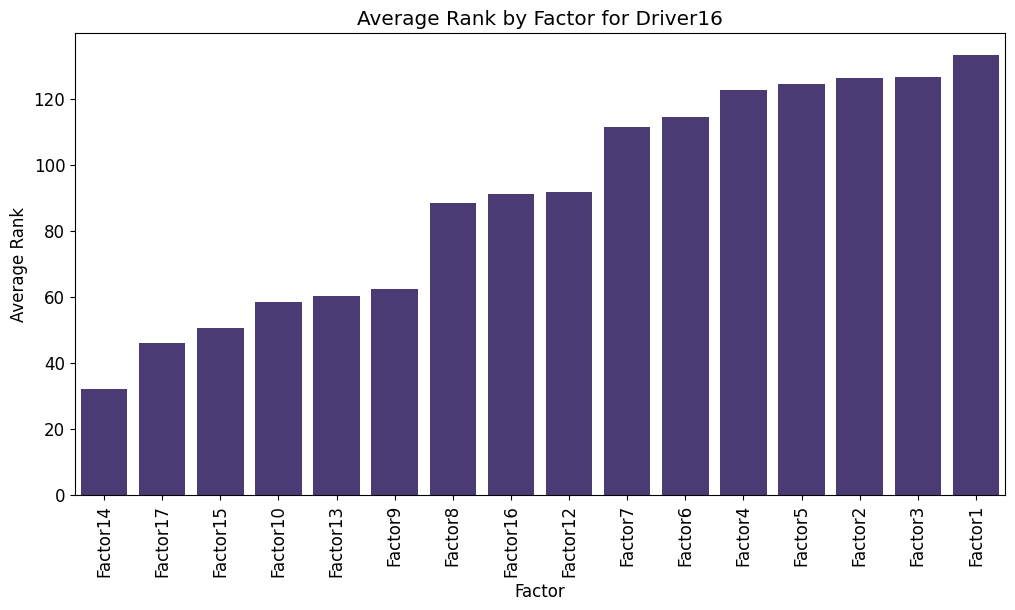

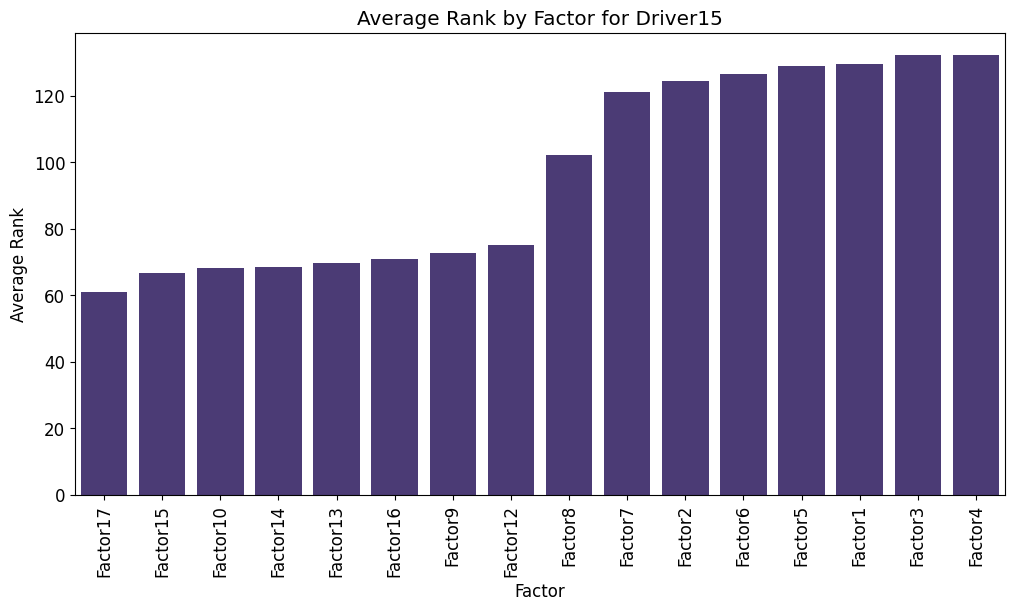

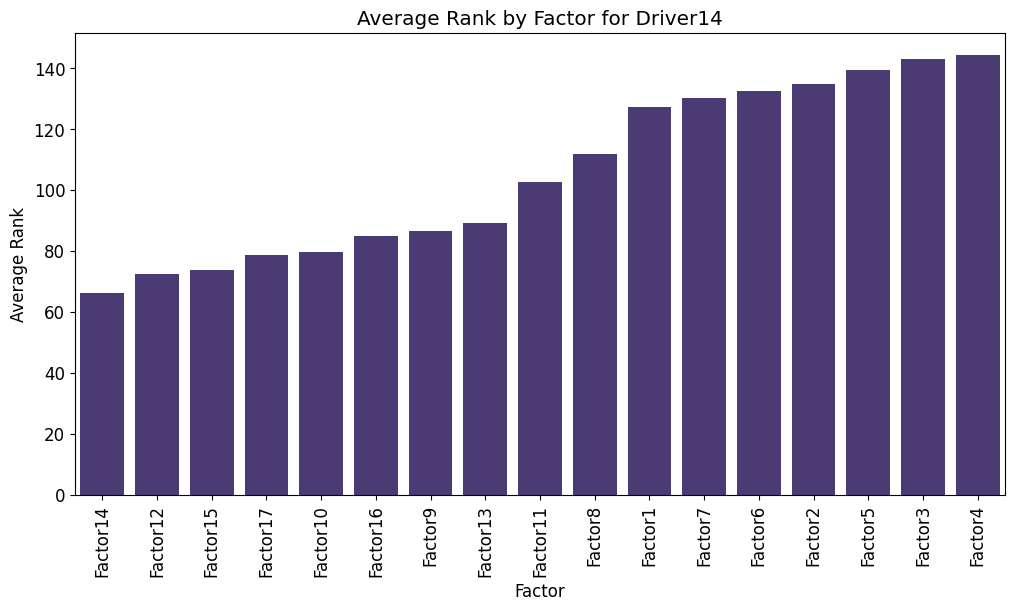

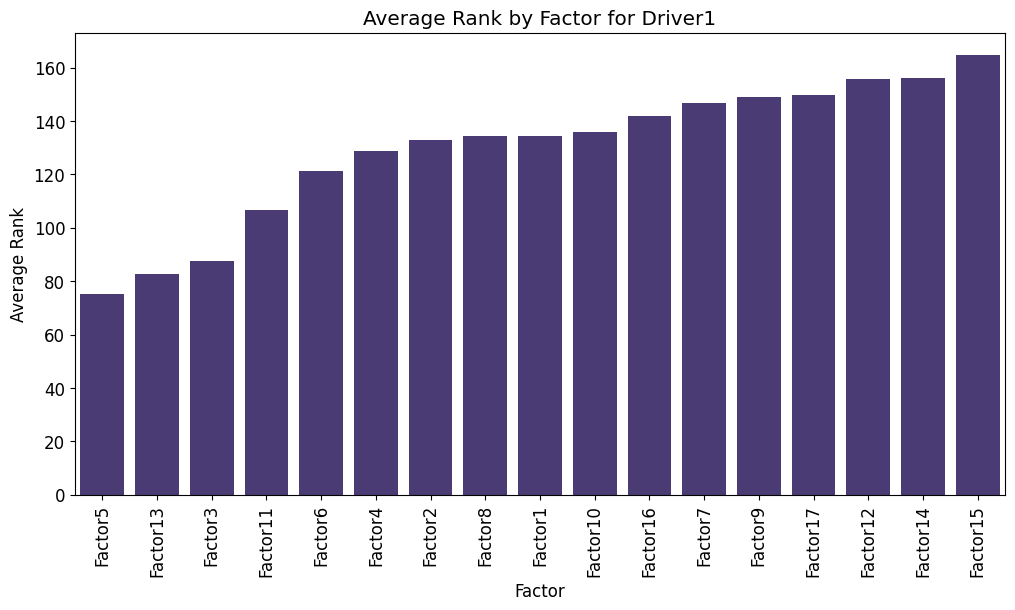

In [5]:
# Analyze driver patterns
factor_stats_df, driver_importance = analyze_driver_patterns(df)


 ## 4. Feature Engineering



 Now we'll create features that capture the temporal nature of the data and the ordinal relationships between drivers and factors.

In [85]:
def engineer_features(df, dimension_reduction=None, n_components=None, variance_threshold=0.99):
    """
    Perform feature engineering 
    
    Args:
        df: Input DataFrame
        dimension_reduction: Method to reduce dimensions ('pca', 'select', None)
        n_components: Number of components to keep (for PCA) or features (for selection)
                     If None and using PCA, will auto-determine based on variance_threshold
        variance_threshold: Target explained variance for automatic PCA component selection (default: 0.99)
        
    Returns:
        Processed DataFrame with new features
    """
    print("\nEngineering features...")
    
    # Create a copy to avoid modifying the original
    processed_df = df.copy()
    
    # Sort by SubjectID and UpdateDT to ensure proper time ordering
    processed_df = processed_df.sort_values(['SubjectID', 'UpdateDT'])
    
    # 1. Add time-based features
    
    # Extract components from date
    processed_df['Year'] = processed_df['UpdateDT'].dt.year
    processed_df['Month'] = processed_df['UpdateDT'].dt.month
    processed_df['DayOfMonth'] = processed_df['UpdateDT'].dt.day
    processed_df['DayOfWeek'] = processed_df['UpdateDT'].dt.dayofweek
    
    # Days since first observation
    min_date = processed_df['UpdateDT'].min()
    processed_df['DaysSinceFirst'] = (processed_df['UpdateDT'] - min_date).dt.days
    
    # Days since previous observation for each subject
    processed_df['DaysSincePrev'] = processed_df.groupby('SubjectID')['UpdateDT'].diff().dt.days
    processed_df['DaysSincePrev'] = processed_df['DaysSincePrev'].fillna(0)
    
    # 2. Add lag features
    
    # Previous rank
    processed_df['PrevRank'] = processed_df.groupby('SubjectID')['Rank'].shift(1)
    
    # Fill missing values with the current rank for the first observation
    # This is a simplification - in practice, you might want to handle this differently
    processed_df['PrevRank'] = processed_df['PrevRank'].fillna(processed_df['Rank'].mean().round(0)) #* processed_df['DaysSinceFirst']/processed_df['DaysSinceFirst']
    
    # Rank change
    processed_df['RankChange'] = processed_df['Rank'] - processed_df['PrevRank'] 
    
    # 3. Create features based on driver positions
    
    # Get all driver columns
    driver_cols = [f'Driver{i}' for i in range(1, 18)]
    
    # For each factor, create a feature indicating its position (if present)
    # This approach avoids one-hot encoding by using positional information
    
    # First, get all unique factors
    all_factors = set()
    for col in driver_cols:
        all_factors.update(processed_df[col].unique())
    
    print(f"Found {len(all_factors)} unique factors across all drivers")
    
    # For each factor, create a position feature
    for factor in all_factors:
        # Initialize position as 0 (not present)
        processed_df[f'{factor}_Position'] = 0
        
        # Update position for each driver where this factor appears
        for i, col in enumerate(driver_cols, 1):
            processed_df.loc[processed_df[col] == factor, f'{factor}_Position'] = i
    
    # Drop original driver columns as we now have positional features
    processed_df_no_drivers = processed_df.drop(columns=driver_cols)
    
    # Create a version with one-hot encoding for comparison
    # We'll use this for models that can't handle ordinal input directly
    processed_df_onehot = pd.get_dummies(
        processed_df, 
        columns=driver_cols, 
        prefix=driver_cols,
        drop_first=False
    )
    
    # 4. Apply dimension reduction if specified
    if dimension_reduction == 'pca':
        # Extract feature columns (excluding non-features)
        exclude_cols = ['SubjectID', 'Rank', 'UpdateDT', 'RankChange']
        feature_cols = [col for col in processed_df_onehot.columns if col not in exclude_cols]
        
        # If n_components is not provided, determine automatically
        if n_components is None:
            # First run PCA with all components to analyze explained variance
            pca_analyzer = PCA()
            pca_analyzer.fit(processed_df_onehot[feature_cols])
            explained_variance = pca_analyzer.explained_variance_ratio_
            cum_explained_variance = np.cumsum(explained_variance)
            
            # Find number of components needed for desired variance threshold
            n_components = np.min(np.where(cum_explained_variance >= variance_threshold)[0]) + 1
            print(f"Automatically selected {n_components} components to explain {variance_threshold*100:.0f}% of variance")
        
        # Apply PCA with determined number of components
        pca = PCA(n_components=n_components)
        pca_features = pca.fit_transform(processed_df_onehot[feature_cols])
        
        # Create PCA feature columns
        pca_df = pd.DataFrame(
            pca_features, 
            columns=[f'PCA_{i+1}' for i in range(n_components)],
            index=processed_df_onehot.index
        )
        
        # Add non-feature columns back
        for col in exclude_cols:
            if col in processed_df_onehot.columns:
                pca_df[col] = processed_df_onehot[col].values
        
        # Show explained variance
        explained_variance = pca.explained_variance_ratio_
        cum_explained_variance = np.cumsum(explained_variance)
        
        print(f"PCA with {n_components} components explains {cum_explained_variance[-1]*100:.2f}% of variance")
        
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(explained_variance) + 1), cum_explained_variance, marker='o')
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.title('PCA Explained Variance')
        plt.grid(True)
        plt.show()
        
        # Return PCA-transformed data
        return pca_df, processed_df_no_drivers, processed_df_onehot, pca
        
    elif dimension_reduction == 'select' and n_components is not None:
        # We'll implement feature selection later when we have a trained model
        # For now, return the full dataset
        return processed_df_no_drivers, processed_df_no_drivers, processed_df_onehot, None
    
    # Return both versions if no dimension reduction
    return processed_df_no_drivers, processed_df_no_drivers, processed_df_onehot, None

In [87]:
# Create engineered features
# Use positional encoding by default (no dimension reduction)
df_positional, df_positional_copy, df_onehot, _ = engineer_features(df)



Engineering features...
Found 17 unique factors across all drivers


 Let's also try with PCA to reduce dimensions


Engineering features...
Found 17 unique factors across all drivers
Automatically selected 3 components to explain 99% of variance
PCA with 3 components explains 99.23% of variance


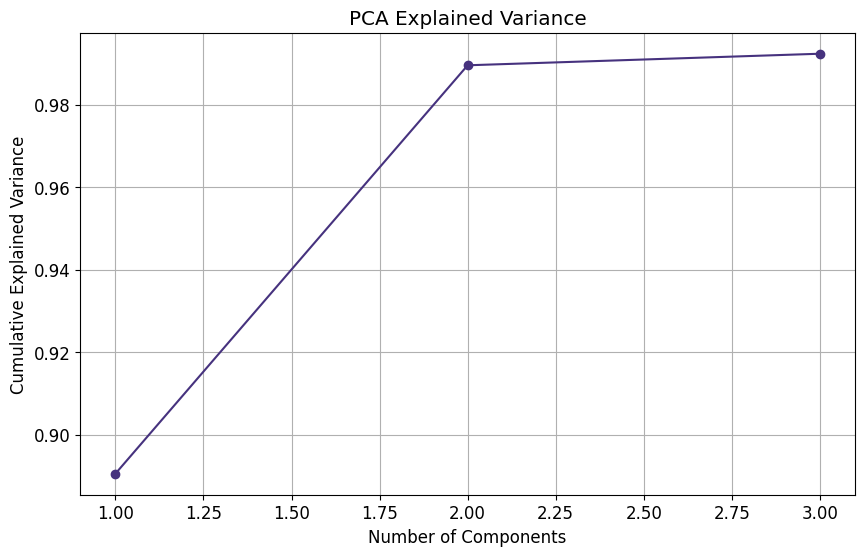

In [86]:
# Create a version with PCA dimension reduction
n_components = None  # Adjust based on explained variance
df_pca, _, _, pca_model = engineer_features(df, dimension_reduction='pca', n_components=n_components)


In [88]:
df_positional.head(5)

SubjectID  Rank            UpdateDT  Year  Month  DayOfMonth  DayOfWeek  \
1022          1   189 2021-05-06 14:13:00  2021      5           6          3   
2100          1   170 2021-05-15 21:41:00  2021      5          15          5   
3401          1   203 2021-05-24 10:53:00  2021      5          24          0   
4114          1   176 2021-06-02 13:51:00  2021      6           2          2   
5680          1   184 2021-06-13 22:57:00  2021      6          13          6   

      DaysSinceFirst  DaysSincePrev  PrevRank  ...  Factor5_Position  \
1022               0            0.0     120.0  ...                14   
2100               9            9.0     189.0  ...                17   
3401              17            8.0     170.0  ...                16   
4114              26            9.0     203.0  ...                16   
5680              38           11.0     176.0  ...                16   

      Factor3_Position  Factor10_Position  Factor9_Position  \
1022                13                  8                12   
2100                14                 13                10   
3401                13                  8                12   
4114                13                  8                12   
5680                13                 12                10   

      Factor13_Position  Factor17_Position  Factor14_Position  \
1022                  6                 11                  2   
2100                  8                  7                  2   
3401                 10                  6                  4   
4114                  9                  6                  4   
5680                  5                  8                  2   

      Factor1_Position  Factor11_Position  Factor7_Position  
1022                 5                  7                 3  
2100                 5                  9                 3  
3401                 5                  7                 2  
4114                 5                  7                 2  
5680                 3                  9                 4  

[5 rows x 28 columns]

 ## 5. Train-Test Split



 We'll use a time-based split to simulate real forecasting conditions.

In [90]:
def prepare_train_test_data(df, test_size=0.2, scaler=None):
    """
    Prepare data for modeling using a time-based split
    
    Args:
        df: Input DataFrame
        test_size: Proportion of data to use for testing
        scaler: Scaler for standardizing features (if None, a new one will be created)
        
    Returns:
        X_train, X_test, y_train, y_test, feature_cols, scaler
    """
    print("\nPreparing data for modeling...")
    
    # Exclude non-feature columns
    exclude_cols = ['SubjectID', 'Rank', 'UpdateDT', 'RankChange', 'Year', 'Month', 'DayOfMonth', 'DayOfWeek', 'Quarter']
    feature_cols = [col for col in df.columns if col not in exclude_cols]
    
    print(f"Selected {len(feature_cols)} features for modeling")
    
    # Sort by date
    df_sorted = df.sort_values('UpdateDT')
    
    # Find split point
    split_idx = int(len(df_sorted) * (1 - test_size))
    split_date = df_sorted.iloc[split_idx]['UpdateDT']
    
    print(f"Splitting data at {split_date} - {split_idx} training samples, {len(df_sorted) - split_idx} test samples")
    
    # Create train and test sets
    train_df = df_sorted[df_sorted['UpdateDT'] <= split_date]
    test_df = df_sorted[df_sorted['UpdateDT'] > split_date]
    
    # Extract features and target
    X_train = train_df[feature_cols]
    y_train = train_df['Rank']
    X_test = test_df[feature_cols]
    y_test = test_df['Rank']
    
    # Scale numerical features
    if scaler is None:
        scaler = StandardScaler()
        
    # Find numerical columns
    numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    # Scale only numeric columns
    if numeric_cols:
        X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
        X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])
    
    print(f"Final shapes - X_train: {X_train.shape}, X_test: {X_test.shape}")
    
    return X_train, X_test, y_train, y_test, feature_cols, scaler


In [91]:
# Prepare data for modeling

# Use positional encoding for models that can handle it well (tree-based)
X_train_pos, X_test_pos, y_train, y_test, feature_cols_pos, scaler_pos = prepare_train_test_data(df_positional)

# Use one-hot encoding for models that need it
X_train_onehot, X_test_onehot, _, _, feature_cols_onehot, scaler_onehot = prepare_train_test_data(df_onehot)

# Use PCA-reduced features for comparison
X_train_pca, X_test_pca, _, _, feature_cols_pca, scaler_pca = prepare_train_test_data(df_pca)



Preparing data for modeling...
Selected 20 features for modeling
Splitting data at 2022-06-03 07:46:00 - 24613 training samples, 6154 test samples
Final shapes - X_train: (25336, 20), X_test: (5431, 20)

Preparing data for modeling...
Selected 304 features for modeling
Splitting data at 2022-06-03 07:46:00 - 24613 training samples, 6154 test samples
Final shapes - X_train: (25336, 304), X_test: (5431, 304)

Preparing data for modeling...
Selected 3 features for modeling
Splitting data at 2022-06-03 07:46:00 - 24613 training samples, 6154 test samples
Final shapes - X_train: (25336, 3), X_test: (5431, 3)


## Hyperparameter Tuning for Models

Let's find the optimal hyperparameters for each model to improve performance.


In [80]:
def tune_random_forest(X_train, y_train, tscv, n_iter=20, verbose=1):
    """
    Tune Random Forest hyperparameters
    
    Args:
        X_train: Training features
        y_train: Training target
        tscv: Time series cross-validation object
        n_iter: Number of parameter combinations to try
        verbose: Verbosity level
        
    Returns:
        Tuned model
    """
    print("\nTuning Random Forest hyperparameters...")
    
    # Define parameter distributions for RandomizedSearchCV
    param_distributions = {
        'n_estimators': randint(50, 300),
        'max_depth': [None] + list(range(5, 51, 10)),
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 10),
        'max_features': ['auto', 'sqrt', 'log2', None]
    }
    
    # Create base model
    rf_base = RandomForestRegressor(random_state=42)
    
    # Create RandomizedSearchCV
    rf_search = RandomizedSearchCV(
        rf_base,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=tscv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=verbose,
        random_state=42
    )
    
    # Fit RandomizedSearchCV
    start_time = time.time()
    rf_search.fit(X_train, y_train)
    tuning_time = time.time() - start_time
    
    # Print results
    print(f"Tuning completed in {tuning_time:.2f} seconds")
    print(f"Best parameters: {rf_search.best_params_}")
    print(f"Best MAE: {-rf_search.best_score_:.2f}")
    
    return rf_search.best_estimator_

def tune_gradient_boosting(X_train, y_train, tscv, n_iter=20, verbose=1):
    """
    Tune Gradient Boosting hyperparameters
    
    Args:
        X_train: Training features
        y_train: Training target
        tscv: Time series cross-validation object
        n_iter: Number of parameter combinations to try
        verbose: Verbosity level
        
    Returns:
        Tuned model
    """
    print("\nTuning Gradient Boosting hyperparameters...")
    
    # Define parameter distributions for RandomizedSearchCV
    param_distributions = {
        'n_estimators': randint(50, 300),
        'learning_rate': uniform(0.01, 0.2),
        'max_depth': randint(3, 10),
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 10),
        'subsample': uniform(0.5, 0.5),
        'max_features': uniform(0.5, 0.5)
    }
    
    # Create base model
    gb_base = GradientBoostingRegressor(random_state=42)
    
    # Create RandomizedSearchCV
    gb_search = RandomizedSearchCV(
        gb_base,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=tscv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=verbose,
        random_state=42
    )
    
    # Fit RandomizedSearchCV
    start_time = time.time()
    gb_search.fit(X_train, y_train)
    tuning_time = time.time() - start_time
    
    # Print results
    print(f"Tuning completed in {tuning_time:.2f} seconds")
    print(f"Best parameters: {gb_search.best_params_}")
    print(f"Best MAE: {-gb_search.best_score_:.2f}")
    
    return gb_search.best_estimator_

def tune_lightgbm(X_train, y_train, tscv, n_iter=20, verbose=1):
    """
    Tune LightGBM hyperparameters
    
    Args:
        X_train: Training features
        y_train: Training target
        tscv: Time series cross-validation object
        n_iter: Number of parameter combinations to try
        verbose: Verbosity level
        
    Returns:
        Tuned model
    """
    print("\nTuning LightGBM hyperparameters...")
    
    # Define parameter distributions for RandomizedSearchCV
    param_distributions = {
        'n_estimators': randint(50, 300),
        'learning_rate': uniform(0.01, 0.2),
        'max_depth': randint(3, 10),
        'num_leaves': randint(20, 100),
        'min_child_samples': randint(10, 50),
        'subsample': uniform(0.5, 0.5),
        'colsample_bytree': uniform(0.5, 0.5)
    }
    
    # Create base model
    lgbm_base = lgbm.LGBMRegressor(random_state=42)
    
    # Create RandomizedSearchCV
    lgbm_search = RandomizedSearchCV(
        lgbm_base,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=tscv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=verbose,
        random_state=42
    )
    
    # Fit RandomizedSearchCV
    start_time = time.time()
    lgbm_search.fit(X_train, y_train)
    tuning_time = time.time() - start_time
    
    # Print results
    print(f"Tuning completed in {tuning_time:.2f} seconds")
    print(f"Best parameters: {lgbm_search.best_params_}")
    print(f"Best MAE: {-lgbm_search.best_score_:.2f}")
    
    return lgbm_search.best_estimator_

def tune_xgboost(X_train, y_train, tscv, n_iter=20, verbose=1):
    """
    Tune XGBoost hyperparameters
    
    Args:
        X_train: Training features
        y_train: Training target
        tscv: Time series cross-validation object
        n_iter: Number of parameter combinations to try
        verbose: Verbosity level
        
    Returns:
        Tuned model
    """
    print("\nTuning XGBoost hyperparameters...")
    
    # Define parameter distributions for RandomizedSearchCV
    param_distributions = {
        'n_estimators': randint(50, 300),
        'learning_rate': uniform(0.01, 0.2),
        'max_depth': randint(3, 10),
        'min_child_weight': randint(1, 10),
        'subsample': uniform(0.5, 0.5),
        'colsample_bytree': uniform(0.5, 0.5),
        'gamma': uniform(0, 1)
    }
    
    # Create base model
    xgb_base = xgb.XGBRegressor(random_state=42)
    
    # Create RandomizedSearchCV
    xgb_search = RandomizedSearchCV(
        xgb_base,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=tscv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=verbose,
        random_state=42
    )
    
    # Fit RandomizedSearchCV
    start_time = time.time()
    xgb_search.fit(X_train, y_train)
    tuning_time = time.time() - start_time
    
    # Print results
    print(f"Tuning completed in {tuning_time:.2f} seconds")
    print(f"Best parameters: {xgb_search.best_params_}")
    print(f"Best MAE: {-xgb_search.best_score_:.2f}")
    
    return xgb_search.best_estimator_

def tune_mord_model(X_train, y_train, tscv, n_iter=10, verbose=1):
    """
    Tune Mord LogisticIT hyperparameters
    
    Args:
        X_train: Training features
        y_train: Training target
        tscv: Time series cross-validation object
        n_iter: Number of parameter combinations to try
        verbose: Verbosity level
        
    Returns:
        Tuned model and label encoder
    """
    print("\nTuning Mord LogisticIT hyperparameters...")
    
    # Preprocess target values for Mord
    # Mord requires a continuous sequence of integers
    label_encoder = LabelEncoder()
    label_encoder.fit(y_train)
    y_train_encoded = label_encoder.transform(y_train)
    
    # Define parameter grid for GridSearchCV
    # Mord has fewer parameters to tune than tree-based models
    param_grid = {
        'alpha': [0.01, 0.1, 1.0, 10.0, 50.0, 100.0]
    }
    
    # For each alpha, we'll manually track performance
    best_alpha = None
    best_score = float('-inf')  # higher is better for neg_mean_absolute_error
    
    start_time = time.time()
    
    # Loop through alpha values
    for alpha in param_grid['alpha']:
        print(f"  Testing alpha={alpha}")
        
        # Initialize model
        model = mord.LogisticIT(alpha=alpha)
        
        # Manual cross-validation
        cv_scores = []
        for train_idx, val_idx in tscv.split(X_train):
            # Split data
            X_cv_train, X_cv_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_cv_train, y_cv_val = y_train_encoded[train_idx], y_train_encoded[val_idx]
            
            # Train model
            model.fit(X_cv_train, y_cv_train)
            
            # Predict and evaluate
            y_cv_pred = model.predict(X_cv_val)
            
            # Transform back to original scale for MAE calculation
            y_val_original = label_encoder.inverse_transform(y_cv_val)
            y_pred_original = label_encoder.inverse_transform(y_cv_pred)
            
            # Calculate MAE
            mae = mean_absolute_error(y_val_original, y_pred_original)
            cv_scores.append(-mae)  # Negate for consistency with sklearn scoring
        
        # Average CV score
        avg_score = np.mean(cv_scores)
        print(f"    Average MAE: {-avg_score:.2f}")
        
        # Track best
        if avg_score > best_score:
            best_score = avg_score
            best_alpha = alpha
    
    tuning_time = time.time() - start_time
    print(f"Tuning completed in {tuning_time:.2f} seconds")
    print(f"Best alpha: {best_alpha}")
    print(f"Best MAE: {-best_score:.2f}")
    
    # Train final model with best alpha
    best_model = mord.LogisticIT(alpha=best_alpha)
    best_model.fit(X_train, y_train_encoded)
    
    return best_model, label_encoder

### Create Time Series Cross-Validation for Tuning

In [68]:
# Create a TimeSeriesSplit for parameter tuning
tscv = TimeSeriesSplit(n_splits=5)

### Set Tuning Flag
Set this to True to run hyperparameter tuning, or False to skip it and use default parameters.


In [69]:
# Flag to control whether to run tuning (can be time consuming)
run_tuning = True  # Set to True to run tuning

### Tune Random Forest Model

In [70]:
if run_tuning:
    # Tune Random Forest with positional features
    rf_tuned = tune_random_forest(X_train_pos, y_train, tscv, n_iter=20)
else:
    rf_tuned = RandomForestRegressor(
        n_estimators=100, 
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42,
        n_jobs=-1
    )



Tuning Random Forest hyperparameters...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Tuning completed in 203.49 seconds
Best parameters: {'max_depth': 25, 'max_features': None, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 278}
Best MAE: 18.83


### Tune Gradient Boosting Model

In [71]:
if run_tuning:
    # Tune Gradient Boosting with positional features
    gb_tuned = tune_gradient_boosting(X_train_pos, y_train, tscv, n_iter=20)
else:
    gb_tuned = GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    )


Tuning Gradient Boosting hyperparameters...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Tuning completed in 175.22 seconds
Best parameters: {'learning_rate': 0.021616722433639893, 'max_depth': 7, 'max_features': 0.8005575058716043, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 199, 'subsample': 0.5282057895135501}
Best MAE: 18.90


### Tune LightGBM Model

In [72]:
if run_tuning:
    # Tune LightGBM with positional features
    lgbm_tuned = tune_lightgbm(X_train_pos, y_train, tscv, n_iter=20)
else:
    lgbm_tuned = lgbm.LGBMRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=-1,
        random_state=42,
        n_jobs=-1
    )



Tuning LightGBM hyperparameters...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 597
[LightGBM] [Info] Number of data points in the train set: 25336, number of used features: 20
[LightGBM] [Info] Start training from score 119.646590
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

### Tune XGBoost Model

In [73]:
if run_tuning:
    # Tune XGBoost with positional features
    xgb_tuned = tune_xgboost(X_train_pos, y_train, tscv, n_iter=20)
else:
    xgb_tuned = xgb.XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42,
        n_jobs=-1
    )


Tuning XGBoost hyperparameters...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Tuning completed in 28.73 seconds
Best parameters: {'colsample_bytree': 0.8777755692715243, 'gamma': 0.22879816549162246, 'learning_rate': 0.0253959819657586, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 135, 'subsample': 0.9402339195076288}
Best MAE: 19.12


 ### Tune Mord Model

In [108]:
run_tuning = False

if run_tuning:
    # Tune Mord LogisticIT with one-hot features
    mord_tuned, label_encoder = tune_mord_model(X_train_onehot, y_train, tscv, n_iter=6)
else:
    # Preprocess for mord without tuning
    label_encoder = LabelEncoder()
    all_y = np.concatenate([y_train, y_test])
    label_encoder.fit(all_y)
    y_train_encoded = label_encoder.transform(y_train)
    
    # Create mord model with default parameters
    mord_tuned = mord.LogisticIT(alpha=50.0)
    mord_tuned.fit(X_train_onehot, y_train_encoded)

 ## 6. Model Training and Evaluation Functions

In [106]:
def evaluate_model(y_true, y_pred, name):
    """
    Evaluate model using multiple metrics suitable for ordinal prediction
    
    Args:
        y_true: True values
        y_pred: Predicted values
        name: Model name
        
    Returns:
        Dictionary of evaluation metrics
    """
    # Standard regression metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    # Rank correlation coefficients
    spearman, _ = spearmanr(y_true, y_pred)
    kendall, _ = kendalltau(y_true, y_pred)
    
    # Custom accuracy metrics - within N ranks
    accuracy_5 = np.mean(np.abs(y_true - y_pred) <= 5)
    accuracy_10 = np.mean(np.abs(y_true - y_pred) <= 10)
    accuracy_20 = np.mean(np.abs(y_true - y_pred) <= 20)
    
    # Print results
    print(f"\n--- {name} Evaluation Results ---")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.4f}")
    print(f"Spearman Correlation: {spearman:.4f}")
    print(f"Kendall's Tau: {kendall:.4f}")
    print(f"Accuracy within 5 ranks: {accuracy_5:.2%}")
    print(f"Accuracy within 10 ranks: {accuracy_10:.2%}")
    print(f"Accuracy within 20 ranks: {accuracy_20:.2%}")
    
    # Return as dictionary
    return {
        'name': name,
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'spearman': spearman,
        'kendall': kendall,
        'accuracy_5': accuracy_5,
        'accuracy_10': accuracy_10,
        'accuracy_20': accuracy_20
    }

def plot_predictions(y_true, y_pred, name):
    """
    Plot actual vs predicted values and error distribution
    
    Args:
        y_true: True values
        y_pred: Predicted values
        name: Model name
    """
    # Plot actual vs predicted
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    
    # Add perfect prediction line
    min_val = min(y_true.min(), min(y_pred))
    max_val = max(y_true.max(), max(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    
    # Add regression line
    z = np.polyfit(y_true, y_pred, 1)
    p = np.poly1d(z)
    plt.plot(sorted(y_true), p(sorted(y_true)), 'g-', linewidth=2)
    
    plt.xlabel('Actual Rank')
    plt.ylabel('Predicted Rank')
    plt.title(f'{name} - Actual vs Predicted')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Plot error distribution
    errors = y_pred - y_true
    plt.figure(figsize=(10, 6))
    sns.histplot(errors, kde=True, bins=30)
    plt.axvline(x=0, color='r', linestyle='--')
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    plt.title(f'{name} - Error Distribution')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Plot errors by true rank
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, errors, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Actual Rank')
    plt.ylabel('Prediction Error')
    plt.title(f'{name} - Error by Actual Rank')
    plt.grid(True, alpha=0.3)
    plt.show()

def train_rf_model(X_train, y_train, X_test, y_test, run_tuning=False, name="Random Forest"):
    """Train and evaluate a Random Forest model"""
    print(f"\nTraining {name}...")
    start_time = time.time()
    
    if run_tuning:
        # Tune Random Forest with positional features
        model = tune_random_forest(X_train, y_train, tscv, n_iter=20)
    else:
        model = RandomForestRegressor(
            n_estimators=100, 
            max_depth=None,
            min_samples_split=2,
            min_samples_leaf=1,
            random_state=42,
            n_jobs=-1
        )
        
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate training time
    train_time = time.time() - start_time
    print(f"Training completed in {train_time:.2f} seconds")
    
    # Evaluate model
    metrics = evaluate_model(y_test, y_pred, name)
    metrics['model'] = model
    metrics['train_time'] = train_time
    
    # Plot predictions
    plot_predictions(y_test, y_pred, name)
    
    return metrics, model

def train_gbdt_model(X_train, y_train, X_test, y_test, run_tuning=False, name="Gradient Boosting"):
    """Train and evaluate a Gradient Boosting model"""
    print(f"\nTraining {name}...")
    start_time = time.time()
    
    if run_tuning:
        # Tune Gradient Boosting with positional features
        model = tune_gradient_boosting(X_train, y_train, tscv, n_iter=20)
    else:
        model = GradientBoostingRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=3,
            random_state=42
        )
    
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate training time
    train_time = time.time() - start_time
    print(f"Training completed in {train_time:.2f} seconds")
    
    # Evaluate model
    metrics = evaluate_model(y_test, y_pred, name)
    metrics['model'] = model
    metrics['train_time'] = train_time
    
    # Plot predictions
    plot_predictions(y_test, y_pred, name)
    
    return metrics, model

def train_lgbm_model(X_train, y_train, X_test, y_test, run_tuning=False, name="LightGBM"):
    """Train and evaluate a LightGBM model"""
    print(f"\nTraining {name}...")
    start_time = time.time()
        
    if run_tuning:
        # Tune LightGBM with positional features
        model = tune_lightgbm(X_train, y_train, tscv, n_iter=20)
    else:
        model = lgbm.LGBMRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=-1,
            random_state=42,
            n_jobs=-1
        )
    
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate training time
    train_time = time.time() - start_time
    print(f"Training completed in {train_time:.2f} seconds")
    
    # Evaluate model
    metrics = evaluate_model(y_test, y_pred, name)
    metrics['model'] = model
    metrics['train_time'] = train_time
    
    # Plot predictions
    plot_predictions(y_test, y_pred, name)
    
    return metrics, model

def train_xgb_model(X_train, y_train, X_test, y_test, run_tuning=False, name="XGBoost"):
    """Train and evaluate an XGBoost model"""
    print(f"\nTraining {name}...")
    start_time = time.time()
        
    if run_tuning:
        # Tune XGBoost with positional features
        model = tune_xgboost(X_train, y_train, tscv, n_iter=20)
    else:
        model = xgb.XGBRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=3,
            random_state=42,
            n_jobs=-1
        )
    
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate training time
    train_time = time.time() - start_time
    print(f"Training completed in {train_time:.2f} seconds")
    
    # Evaluate model
    metrics = evaluate_model(y_test, y_pred, name)
    metrics['model'] = model
    metrics['train_time'] = train_time
    
    # Plot predictions
    plot_predictions(y_test, y_pred, name)
    
    return metrics, model

def train_mord_model(X_train, y_train, X_test, y_test, tuned_model=None, label_encoder=None, name="Mord Ordinal"):
    """Train and evaluate a Mord ordinal regression model"""
    print(f"\nTraining {name}...")
    start_time = time.time()
    
    # Use provided encoder or create new one
    if label_encoder is None:
        # Preprocess target values for Mord
        label_encoder = LabelEncoder()
        # Fit encoder on all possible values
        all_y = np.concatenate([y_train, y_test])
        label_encoder.fit(all_y)
    
    # Transform train set
    y_train_encoded = label_encoder.transform(y_train)
    
    # Use tuned model if provided
    if tuned_model is not None:
        model = tuned_model
    else:
        # Initialize default model
        model = mord.LogisticIT(alpha=50.0)
        model.fit(X_train, y_train_encoded)
    
    # Make predictions (encoded)
    y_pred_encoded = model.predict(X_test)
    
    # Transform predictions back to original scale
    y_pred = label_encoder.inverse_transform(y_pred_encoded)
    
    # Calculate training time
    train_time = time.time() - start_time
    print(f"Training completed in {train_time:.2f} seconds")
    
    # Evaluate model
    metrics = evaluate_model(y_test, y_pred, name)
    metrics['model'] = model
    metrics['train_time'] = train_time
    metrics['label_encoder'] = label_encoder
    
    # Plot predictions
    plot_predictions(y_test, y_pred, name)
    
    return metrics, model


 ## 7. Train and Evaluate Models


Training Random Forest (Positional)...

Tuning Random Forest hyperparameters...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Tuning completed in 191.86 seconds
Best parameters: {'max_depth': 25, 'max_features': None, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 278}
Best MAE: 18.83
Training completed in 233.15 seconds

--- Random Forest (Positional) Evaluation Results ---
MAE: 17.48
RMSE: 24.98
R²: 0.8049
Spearman Correlation: 0.8938
Kendall's Tau: 0.7380
Accuracy within 5 ranks: 22.17%
Accuracy within 10 ranks: 42.75%
Accuracy within 20 ranks: 69.27%


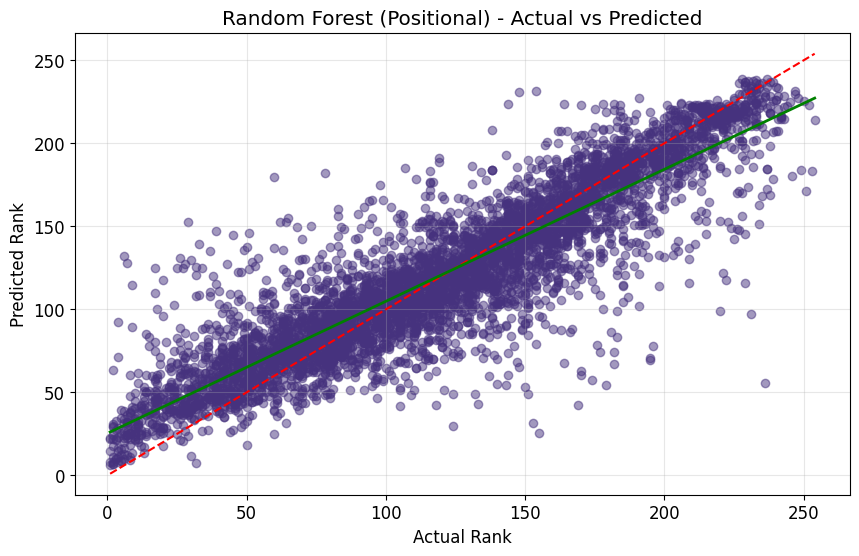

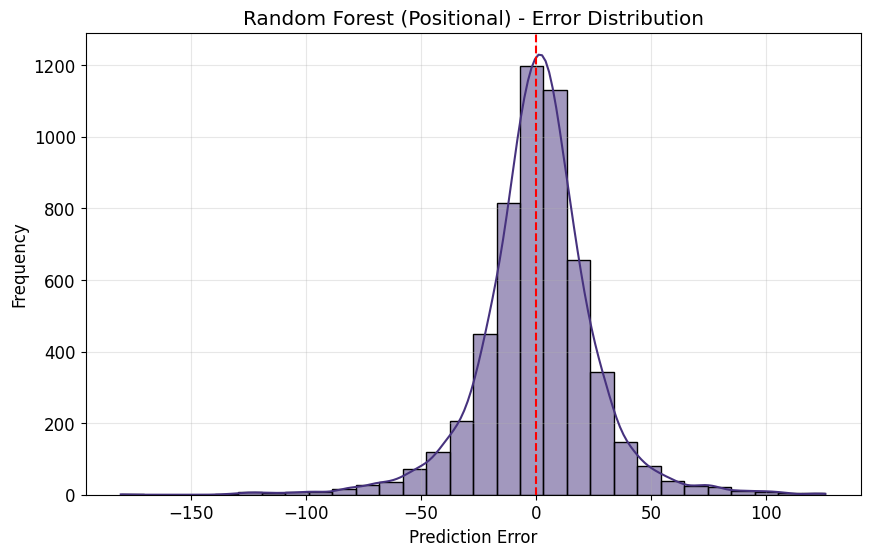

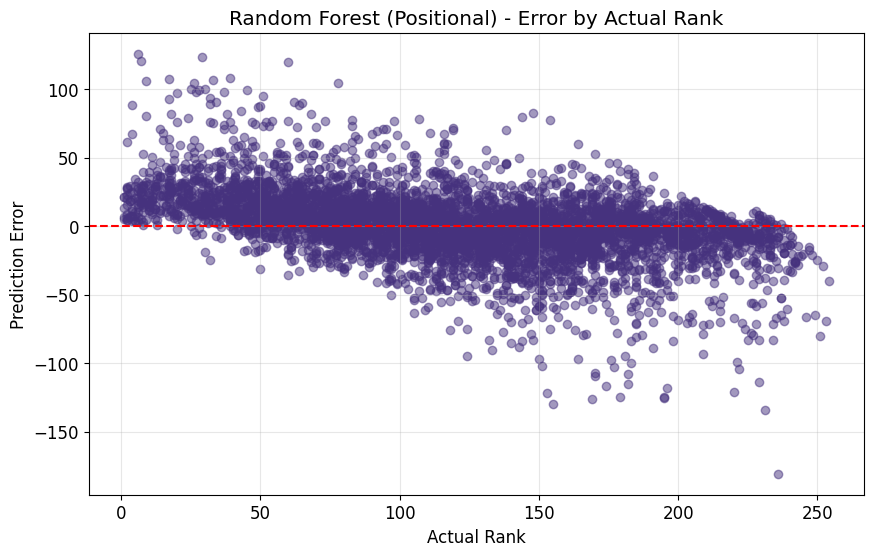


Training Gradient Boosting (Positional)...

Tuning Gradient Boosting hyperparameters...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Tuning completed in 228.49 seconds
Best parameters: {'learning_rate': 0.021616722433639893, 'max_depth': 7, 'max_features': 0.8005575058716043, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 199, 'subsample': 0.5282057895135501}
Best MAE: 18.90
Training completed in 250.07 seconds

--- Gradient Boosting (Positional) Evaluation Results ---
MAE: 17.51
RMSE: 24.92
R²: 0.8059
Spearman Correlation: 0.8943
Kendall's Tau: 0.7377
Accuracy within 5 ranks: 22.83%
Accuracy within 10 ranks: 42.68%
Accuracy within 20 ranks: 69.23%


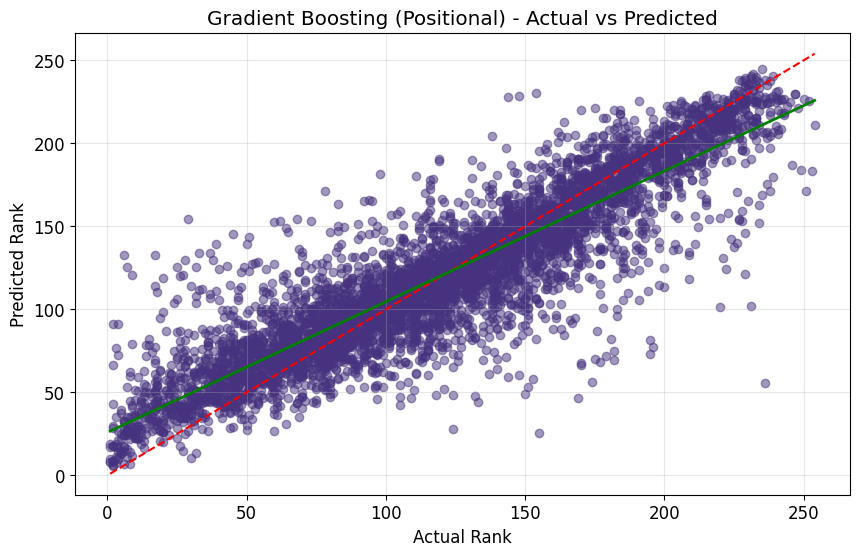

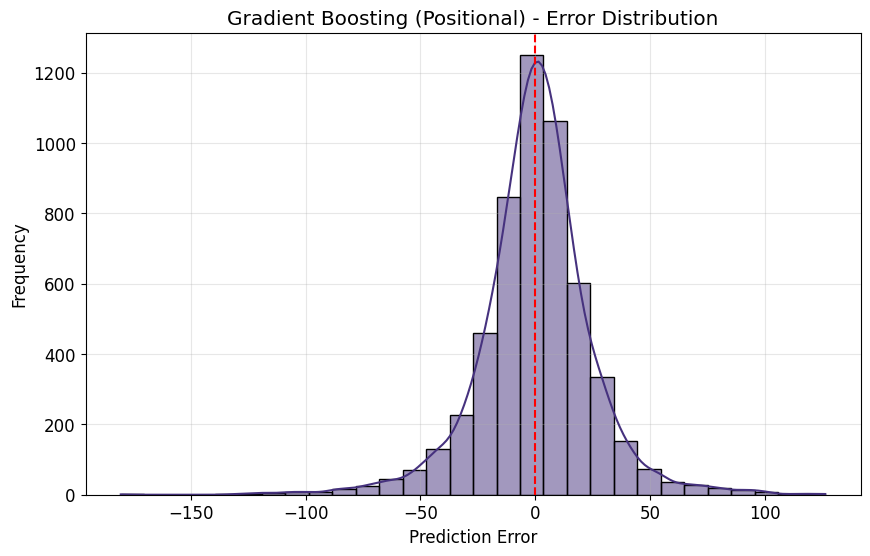

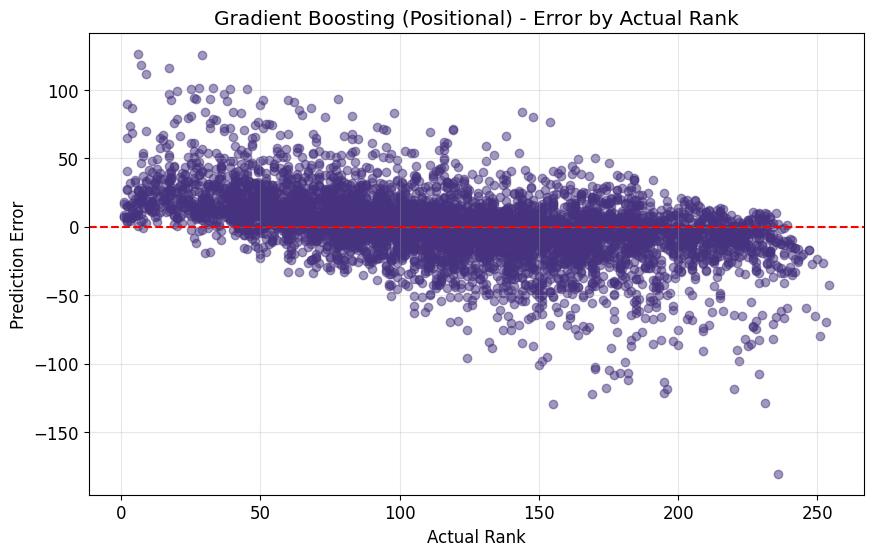


Training LightGBM (Positional)...

Tuning LightGBM hyperparameters...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 597
[LightGBM] [Info] Number of data points in the train set: 25336, number of used features: 20
[LightGBM] [Info] Start training from score 119.646590
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

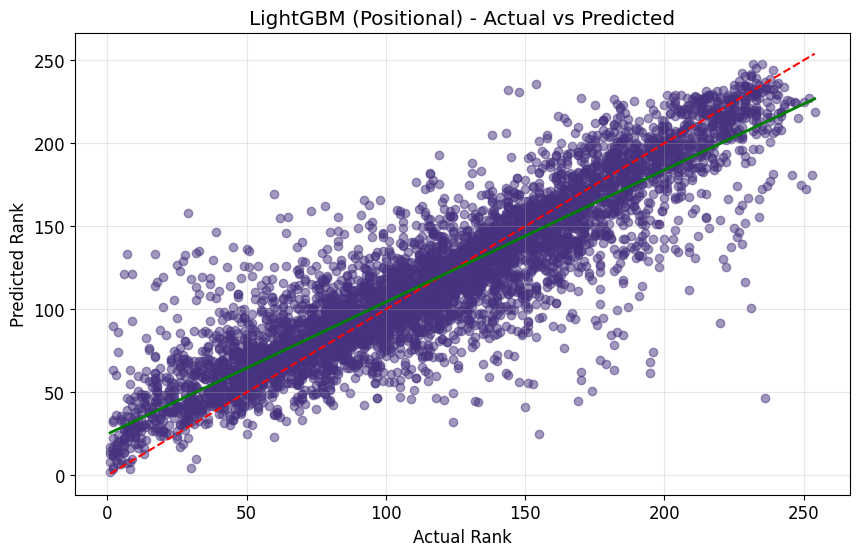

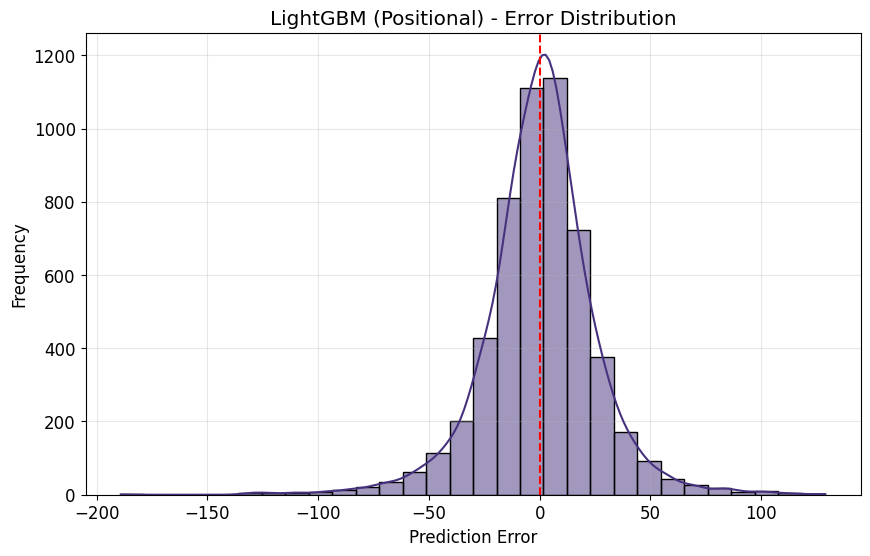

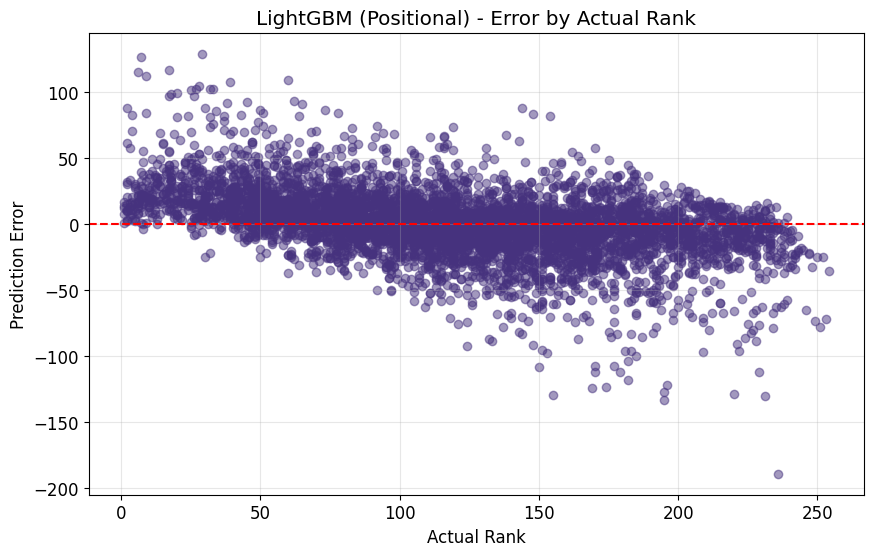


Training XGBoost (Positional)...

Tuning XGBoost hyperparameters...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Tuning completed in 27.50 seconds
Best parameters: {'colsample_bytree': 0.8777755692715243, 'gamma': 0.22879816549162246, 'learning_rate': 0.0253959819657586, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 135, 'subsample': 0.9402339195076288}
Best MAE: 19.12
Training completed in 28.12 seconds

--- XGBoost (Positional) Evaluation Results ---
MAE: 17.68
RMSE: 25.11
R²: 0.8030
Spearman Correlation: 0.8929
Kendall's Tau: 0.7384
Accuracy within 5 ranks: 22.17%
Accuracy within 10 ranks: 41.43%
Accuracy within 20 ranks: 68.46%


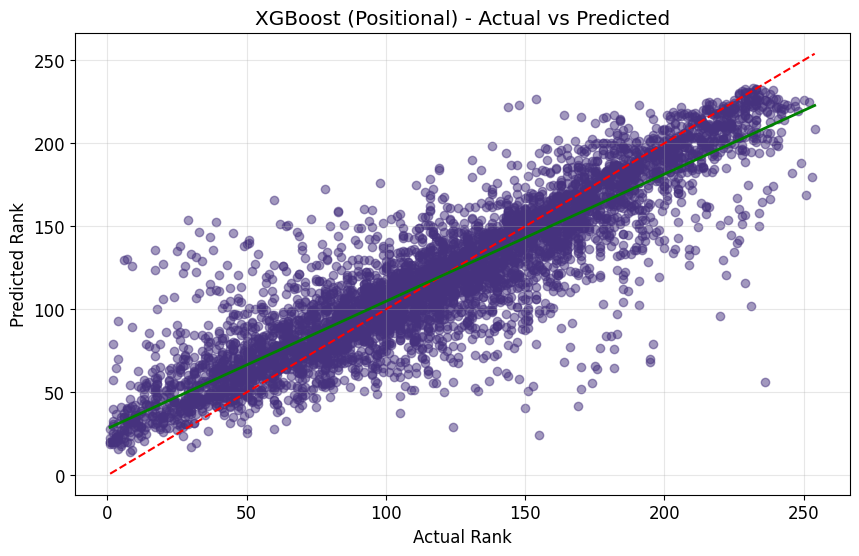

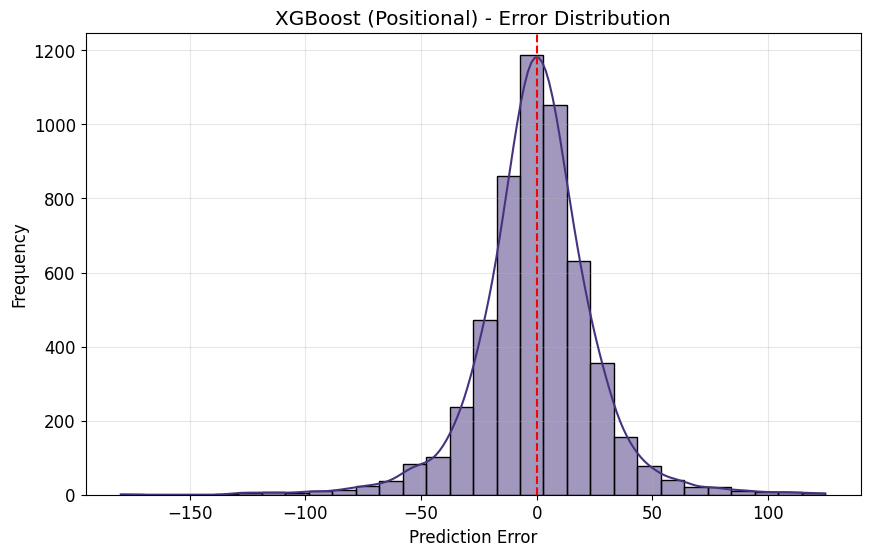

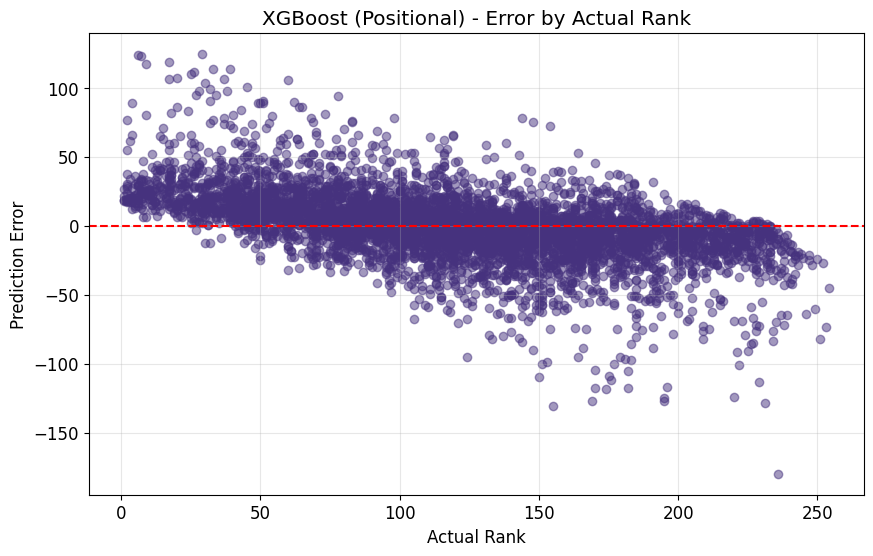

In [81]:
# Dictionary to store model results
model_results = {}

# Train models with positional features
rf_metrics, rf_model = train_rf_model(X_train_pos, y_train, X_test_pos, y_test, run_tuning=True, name="Random Forest (Positional)")
model_results["Random Forest (Positional)"] = rf_metrics

gb_metrics, gb_model = train_gbdt_model(X_train_pos, y_train, X_test_pos, y_test, run_tuning=True, name="Gradient Boosting (Positional)")
model_results["Gradient Boosting (Positional)"] = gb_metrics

lgbm_metrics, lgbm_model = train_lgbm_model(X_train_pos, y_train, X_test_pos, y_test, run_tuning=True,  name="LightGBM (Positional)")
model_results["LightGBM (Positional)"] = lgbm_metrics

xgb_metrics, xgb_model = train_xgb_model(X_train_pos, y_train, X_test_pos, y_test, run_tuning=True, name="XGBoost (Positional)")
model_results["XGBoost (Positional)"] = xgb_metrics


 Now let's try models with one-hot encoding


Training Random Forest (One-Hot)...

Tuning Random Forest hyperparameters...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Tuning completed in 929.41 seconds
Best parameters: {'max_depth': 25, 'max_features': None, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 278}
Best MAE: 18.85
Training completed in 1179.49 seconds

--- Random Forest (One-Hot) Evaluation Results ---
MAE: 17.45
RMSE: 25.01
R²: 0.8046
Spearman Correlation: 0.8935
Kendall's Tau: 0.7383
Accuracy within 5 ranks: 22.61%
Accuracy within 10 ranks: 42.83%
Accuracy within 20 ranks: 69.40%


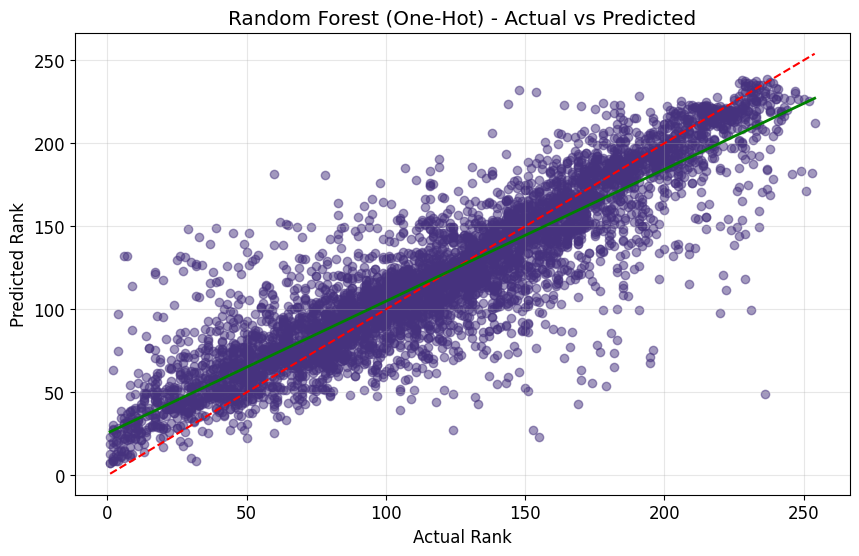

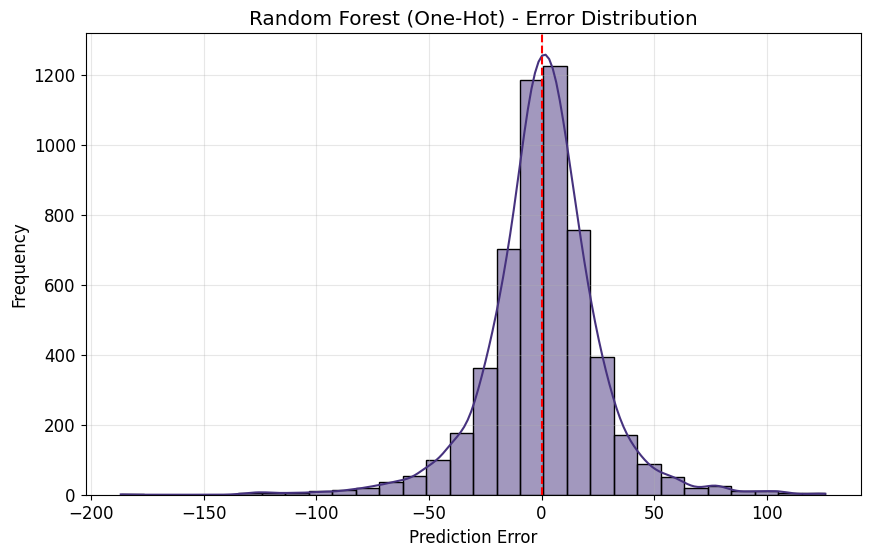

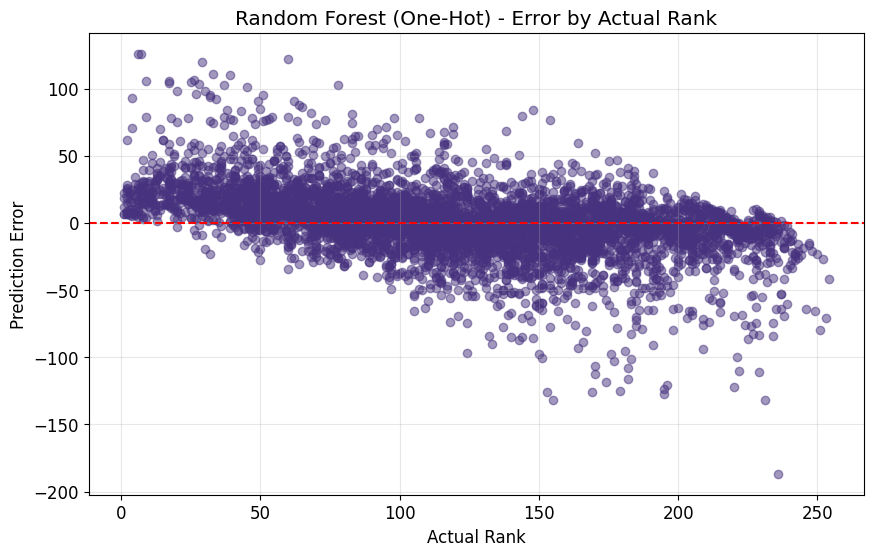


Training Gradient Boosting (One-Hot)...

Tuning Gradient Boosting hyperparameters...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Tuning completed in 828.63 seconds
Best parameters: {'learning_rate': 0.021616722433639893, 'max_depth': 7, 'max_features': 0.8005575058716043, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 199, 'subsample': 0.5282057895135501}
Best MAE: 18.86
Training completed in 874.32 seconds

--- Gradient Boosting (One-Hot) Evaluation Results ---
MAE: 17.50
RMSE: 24.96
R²: 0.8053
Spearman Correlation: 0.8941
Kendall's Tau: 0.7375
Accuracy within 5 ranks: 22.98%
Accuracy within 10 ranks: 43.09%
Accuracy within 20 ranks: 68.99%


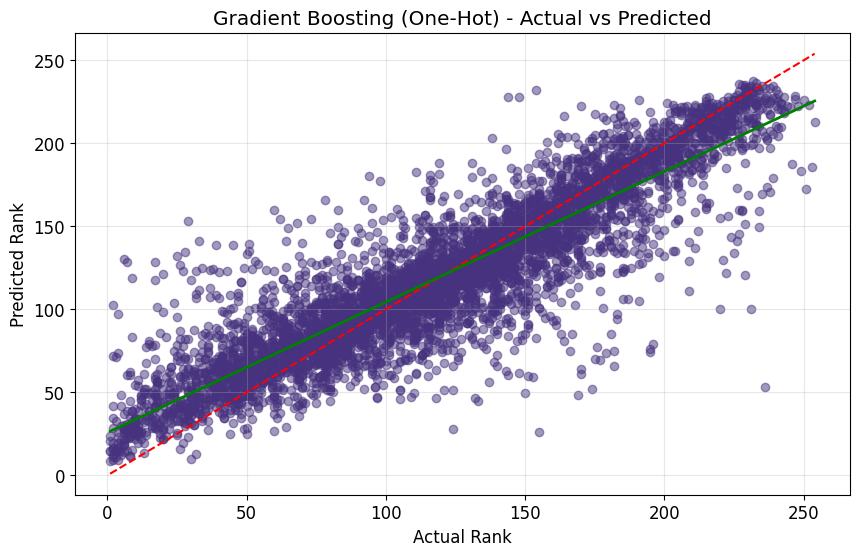

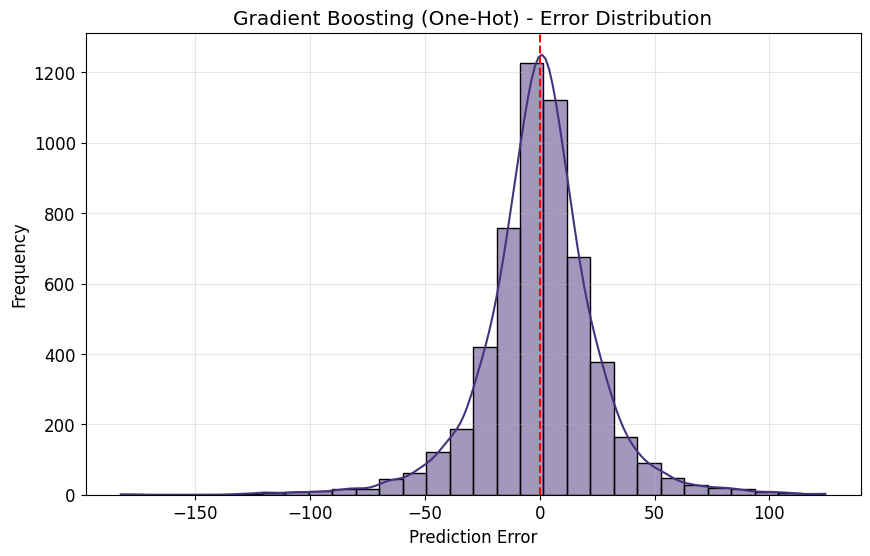

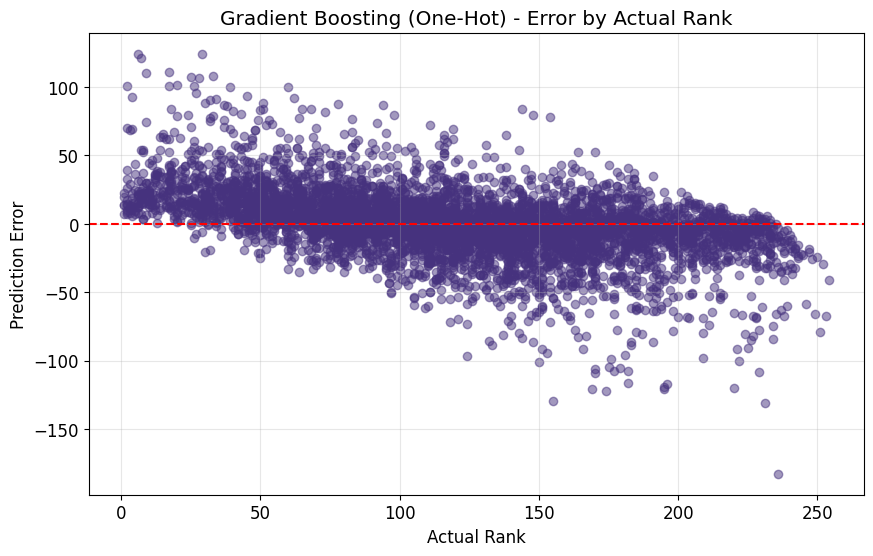


Training LightGBM (One-Hot)...

Tuning LightGBM hyperparameters...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1119
[LightGBM] [Info] Number of data points in the train set: 25336, number of used features: 281
[LightGBM] [Info] Start training from score 119.646590
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


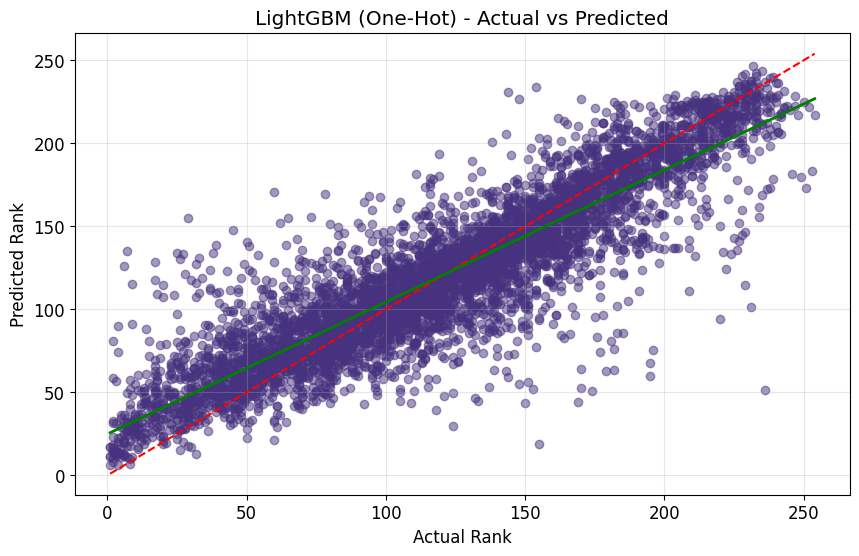

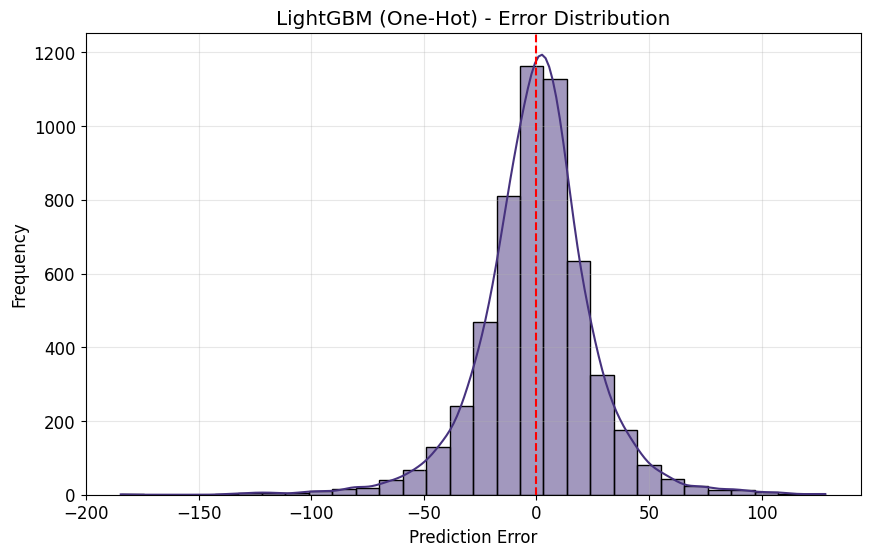

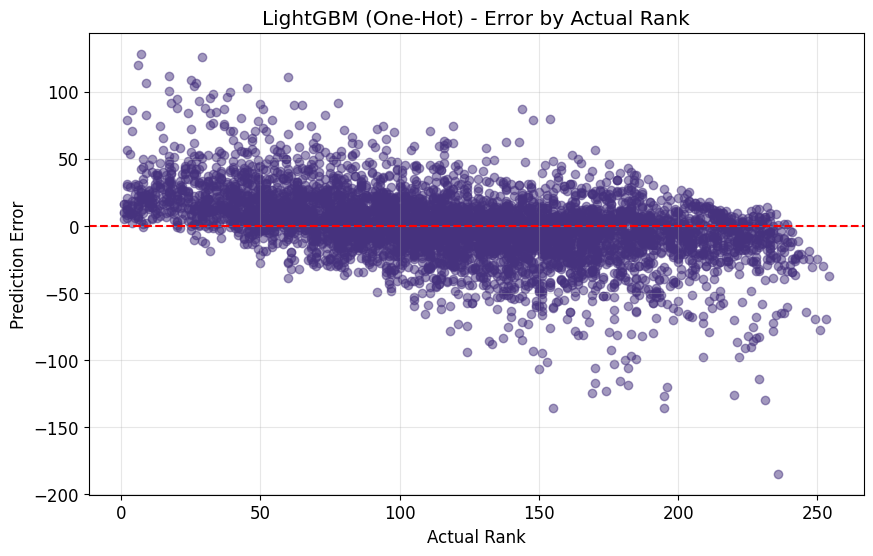

In [82]:
# Train models with one-hot features
rf_onehot_metrics, rf_onehot_model = train_rf_model(X_train_onehot, y_train, X_test_onehot, y_test, run_tuning=True, name="Random Forest (One-Hot)")
model_results["Random Forest (One-Hot)"] = rf_onehot_metrics

gb_onehot_metrics, gb_onehot_model = train_gbdt_model(X_train_onehot, y_train, X_test_onehot, y_test, run_tuning=True, name="Gradient Boosting (One-Hot)")
model_results["Gradient Boosting (One-Hot)"] = gb_onehot_metrics

lgbm_onehot_metrics, lgbm_onehot_model = train_lgbm_model(X_train_onehot, y_train, X_test_onehot, y_test, run_tuning=True, name="LightGBM (One-Hot)")
model_results["LightGBM (One-Hot)"] = lgbm_onehot_metrics


 And finally, let's try models with PCA-reduced features


Training Random Forest (PCA)...

Tuning Random Forest hyperparameters...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Tuning completed in 138.32 seconds
Best parameters: {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 9, 'min_samples_split': 15, 'n_estimators': 291}
Best MAE: 20.18
Training completed in 152.19 seconds

--- Random Forest (PCA) Evaluation Results ---
MAE: 17.56
RMSE: 26.26
R²: 0.7845
Spearman Correlation: 0.8825
Kendall's Tau: 0.7379
Accuracy within 5 ranks: 23.05%
Accuracy within 10 ranks: 45.57%
Accuracy within 20 ranks: 70.91%


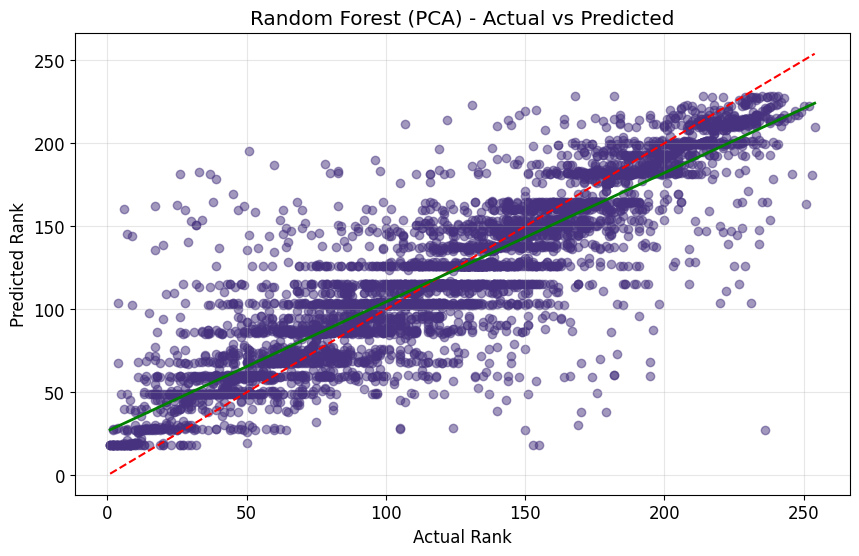

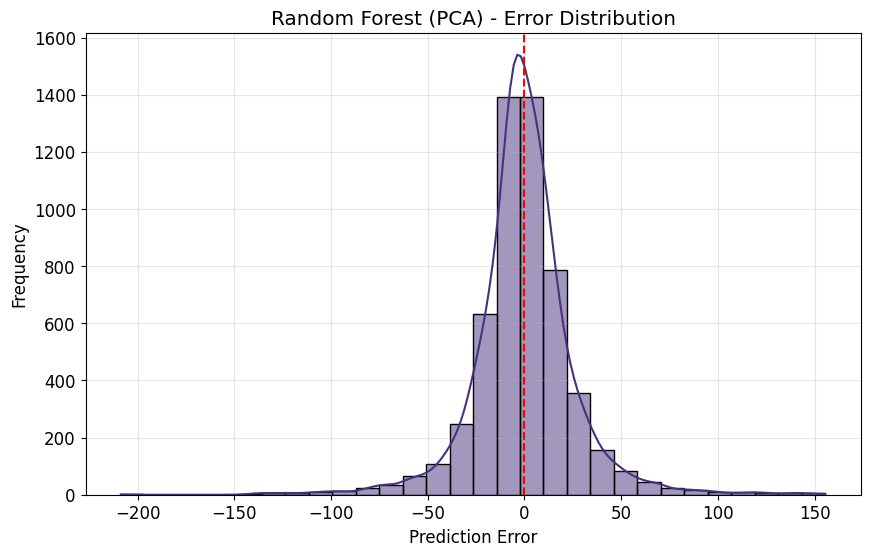

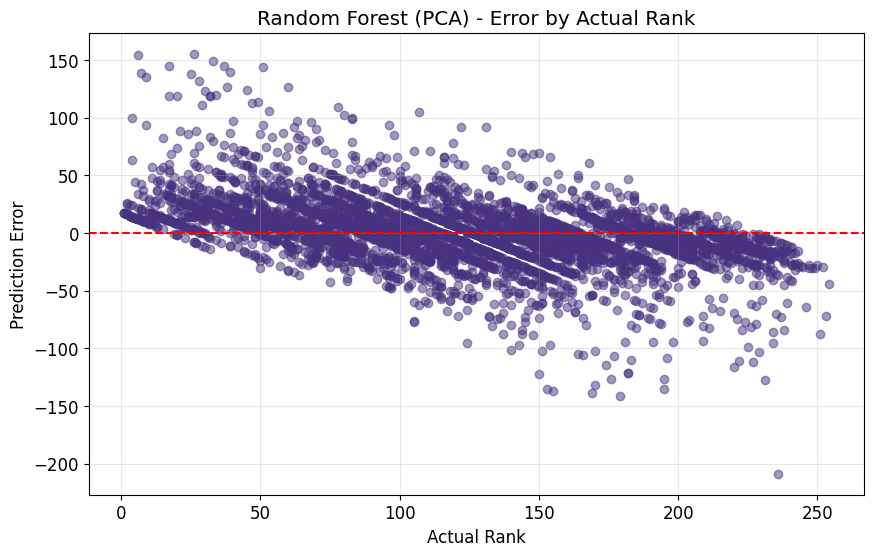


Training Gradient Boosting (PCA)...

Tuning Gradient Boosting hyperparameters...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Tuning completed in 118.55 seconds
Best parameters: {'learning_rate': 0.15580143360819748, 'max_depth': 3, 'max_features': 0.8029799873905057, 'min_samples_leaf': 7, 'min_samples_split': 10, 'n_estimators': 77, 'subsample': 0.9315517129377968}
Best MAE: 25.29
Training completed in 121.30 seconds

--- Gradient Boosting (PCA) Evaluation Results ---
MAE: 35.01
RMSE: 44.50
R²: 0.3811
Spearman Correlation: 0.8575
Kendall's Tau: 0.6974
Accuracy within 5 ranks: 12.39%
Accuracy within 10 ranks: 23.42%
Accuracy within 20 ranks: 38.69%


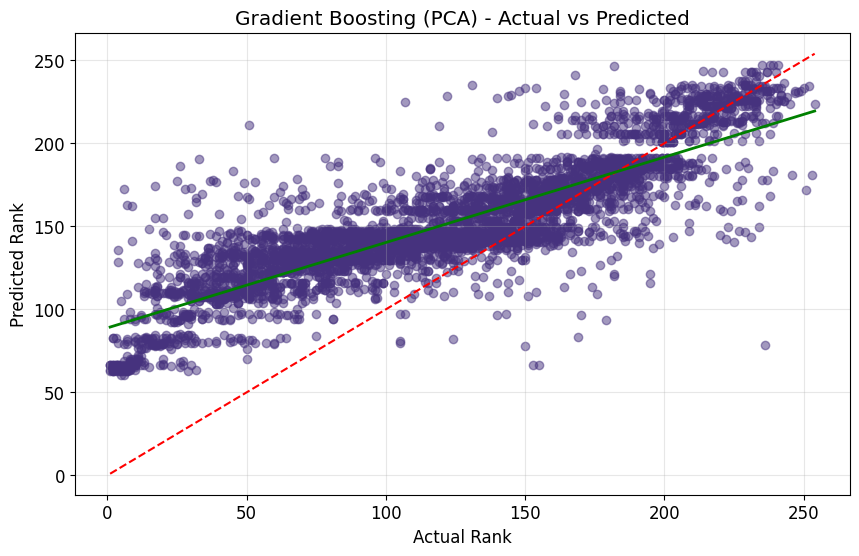

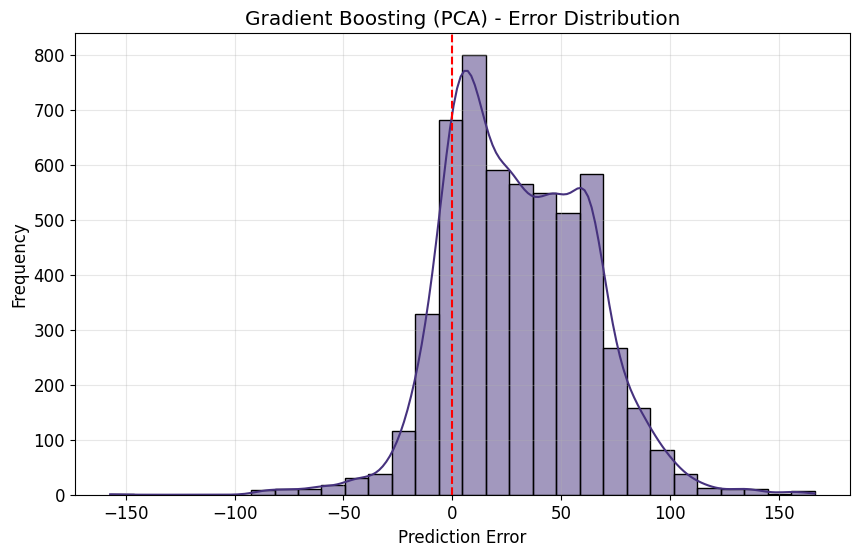

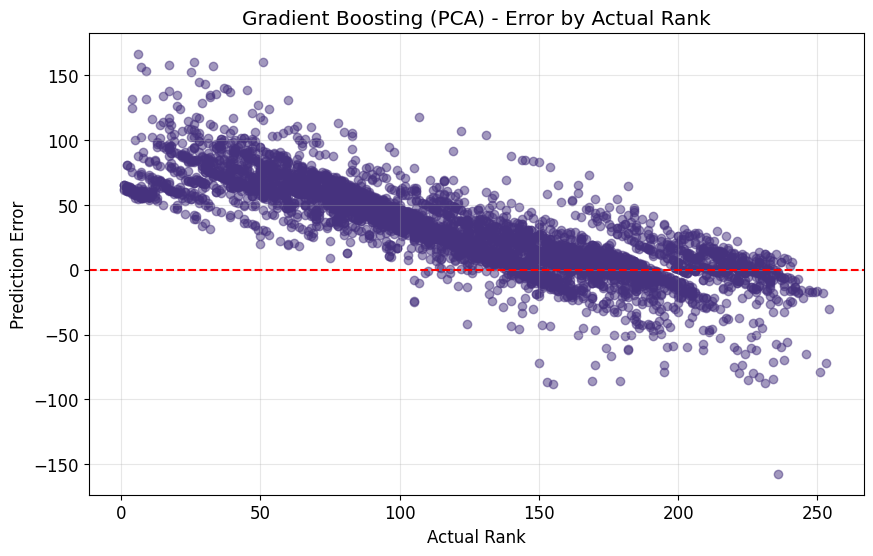

In [92]:
# Train models with PCA features
rf_pca_metrics, rf_pca_model = train_rf_model(X_train_pca, y_train, X_test_pca, y_test, run_tuning=True, name="Random Forest (PCA)")
model_results["Random Forest (PCA)"] = rf_pca_metrics

gb_pca_metrics, gb_pca_model = train_gbdt_model(X_train_pca, y_train, X_test_pca, y_test, run_tuning=True, name="Gradient Boosting (PCA)")
model_results["Gradient Boosting (PCA)"] = gb_pca_metrics


 Now let's try the ordinal regression model with mord


Training Mord LogisticIT (One-Hot)...
Training completed in 0.24 seconds

--- Mord LogisticIT (One-Hot) Evaluation Results ---
MAE: 108.86
RMSE: 124.20
R²: -3.8211
Spearman Correlation: 0.1314
Kendall's Tau: 0.0974
Accuracy within 5 ranks: 1.64%
Accuracy within 10 ranks: 3.20%
Accuracy within 20 ranks: 6.52%


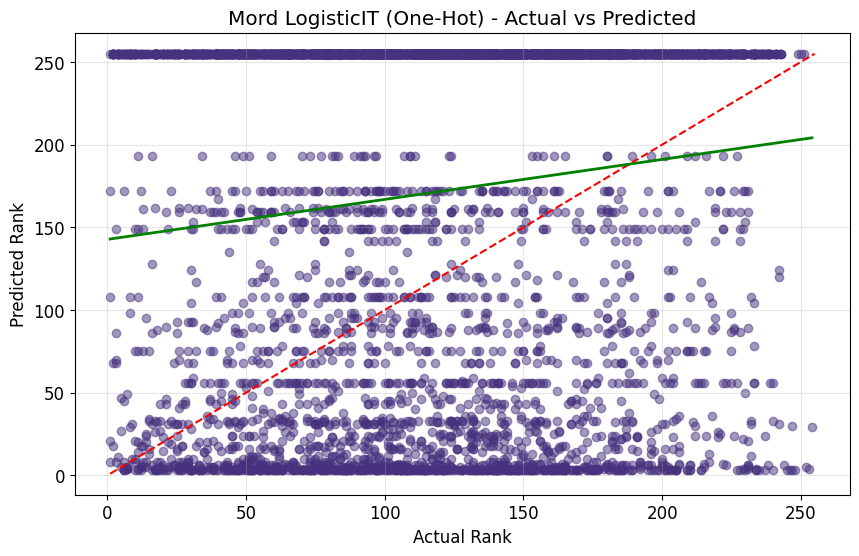

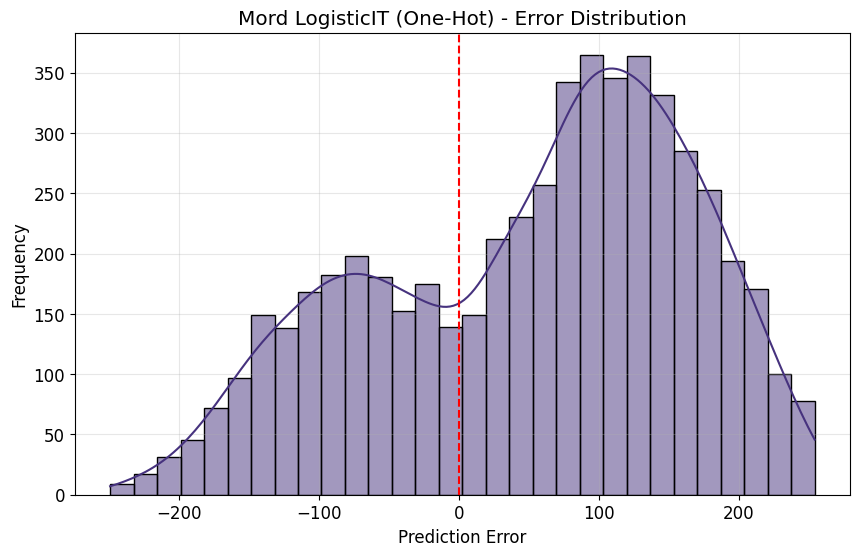

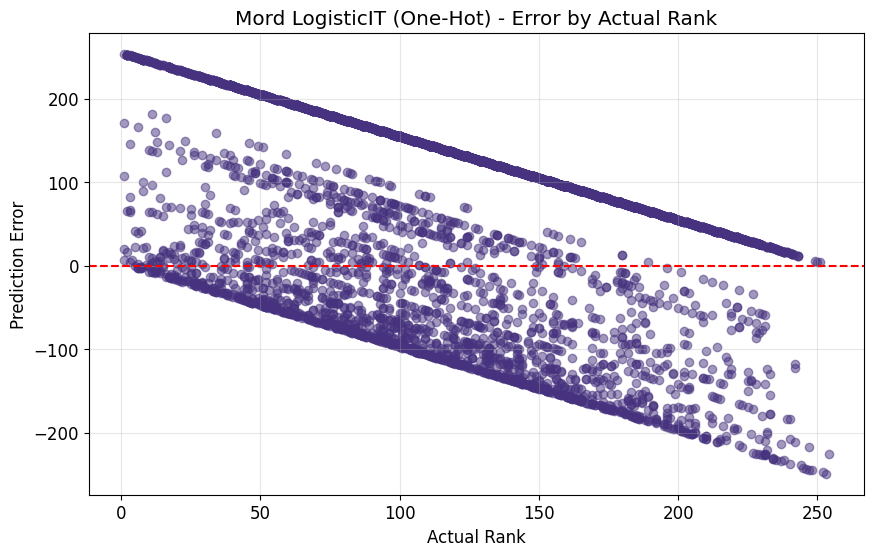

In [109]:
# Train Mord model with one-hot features (better for linear models)
mord_metrics, mord_model = train_mord_model(
    X_train_onehot, y_train, X_test_onehot, y_test,
    tuned_model=mord_tuned,
    label_encoder=label_encoder if 'label_encoder' in locals() else None,
    name="Mord LogisticIT (One-Hot)"
)
model_results["Mord LogisticIT (One-Hot)"] = mord_metrics


 ## 8. Model Comparison

In [93]:
def compare_models(model_results):
    """
    Compare model performance across multiple metrics
    
    Args:
        model_results: Dictionary with model metrics
    """
    # Create a DataFrame with all results
    models = []
    
    for model_name, metrics in model_results.items():
        model_data = {
            'Model': model_name,
            'MAE': metrics['mae'],
            'RMSE': metrics['rmse'],
            'R²': metrics['r2'],
            'Spearman': metrics['spearman'],
            'Kendall': metrics['kendall'],
            'Accuracy ≤5': metrics['accuracy_5'],
            'Accuracy ≤10': metrics['accuracy_10'],
            'Accuracy ≤20': metrics['accuracy_20'],
            'Training Time (s)': metrics['train_time']
        }
        models.append(model_data)
    
    # Create DataFrame and sort by MAE
    comparison_df = pd.DataFrame(models).sort_values('MAE')
    
    print("\n--- Model Comparison ---")
    print(comparison_df)
    
    # Create comparison visualizations
    metrics_to_plot = ['MAE', 'RMSE', 'R²', 'Spearman', 'Accuracy ≤10']
    
    for metric in metrics_to_plot:
        plt.figure(figsize=(12, 6))
        
        # Sort by metric
        if metric in ['MAE', 'RMSE']:
            # Lower is better
            sorted_df = comparison_df.sort_values(metric)
        else:
            # Higher is better
            sorted_df = comparison_df.sort_values(metric, ascending=False)
        
        # Create bar chart
        sns.barplot(x='Model', y=metric, data=sorted_df)
        plt.title(f'Model Comparison - {metric}')
        plt.xlabel('Model')
        plt.ylabel(metric)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    
    # Create radar chart for top models
    top_models = comparison_df.head(4)['Model'].tolist()
    
    # Set up the radar chart
    metrics_for_radar = ['R²', 'Spearman', 'Accuracy ≤5', 'Accuracy ≤10', 'Accuracy ≤20']
    
    # Filter for selected models and metrics
    radar_df = comparison_df[comparison_df['Model'].isin(top_models)][['Model'] + metrics_for_radar]
    
    # Number of variables
    N = len(metrics_for_radar)
    
    # Create angle for each variable
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    
    # Draw one line per model and fill area
    for i, model in enumerate(top_models):
        values = radar_df[radar_df['Model'] == model][metrics_for_radar].values.flatten().tolist()
        values += values[:1]  # Close the loop
        
        # Plot values
        ax.plot(angles, values, linewidth=2, label=model)
        ax.fill(angles, values, alpha=0.1)
    
    # Fix axis to go in the right order and start at 12 o'clock
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    
    # Draw axis lines for each angle and label
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics_for_radar)
    
    # Draw y labels
    ax.set_rlabel_position(0)
    
    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title("Model Comparison - Radar Chart", size=15)
    plt.show()
    
    # Return the best model based on MAE
    best_model_name = comparison_df.iloc[0]['Model']
    print(f"\nBest model based on MAE: {best_model_name}")
    print(f"MAE: {comparison_df.iloc[0]['MAE']:.2f}")
    
    return comparison_df



--- Model Comparison ---
                            Model         MAE        RMSE        R²  Spearman  \
4         Random Forest (One-Hot)   17.454887   25.007762  0.804552  0.893509   
0      Random Forest (Positional)   17.484625   24.984355  0.804917  0.893810   
5     Gradient Boosting (One-Hot)   17.496262   24.960719  0.805286  0.894054   
1  Gradient Boosting (Positional)   17.509460   24.923790  0.805862  0.894350   
7             Random Forest (PCA)   17.556948   26.258193  0.784517  0.882528   
3            XGBoost (Positional)   17.683500   25.110006  0.802950  0.892926   
6              LightGBM (One-Hot)   18.008849   25.334227  0.799415  0.891038   
2           LightGBM (Positional)   18.097685   25.396412  0.798429  0.890838   
8         Gradient Boosting (PCA)   35.007827   44.501878  0.381073  0.857544   
9       Mord LogisticIT (One-Hot)  108.859878  124.203209 -3.821122  0.131439   

    Kendall  Accuracy ≤5  Accuracy ≤10  Accuracy ≤20  Training Time (s)  
4  0.738

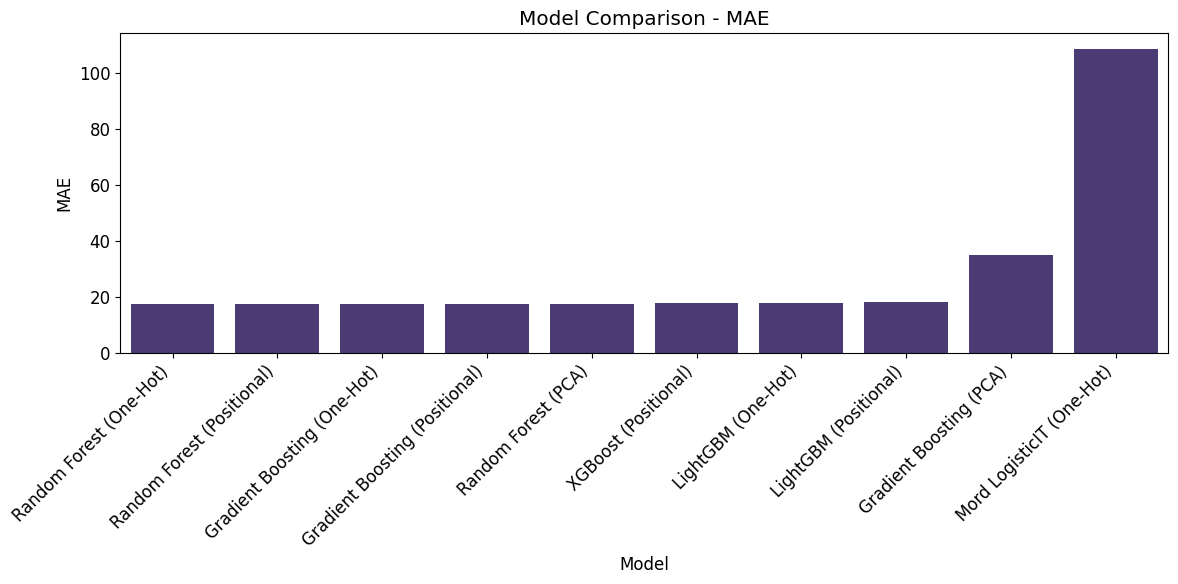

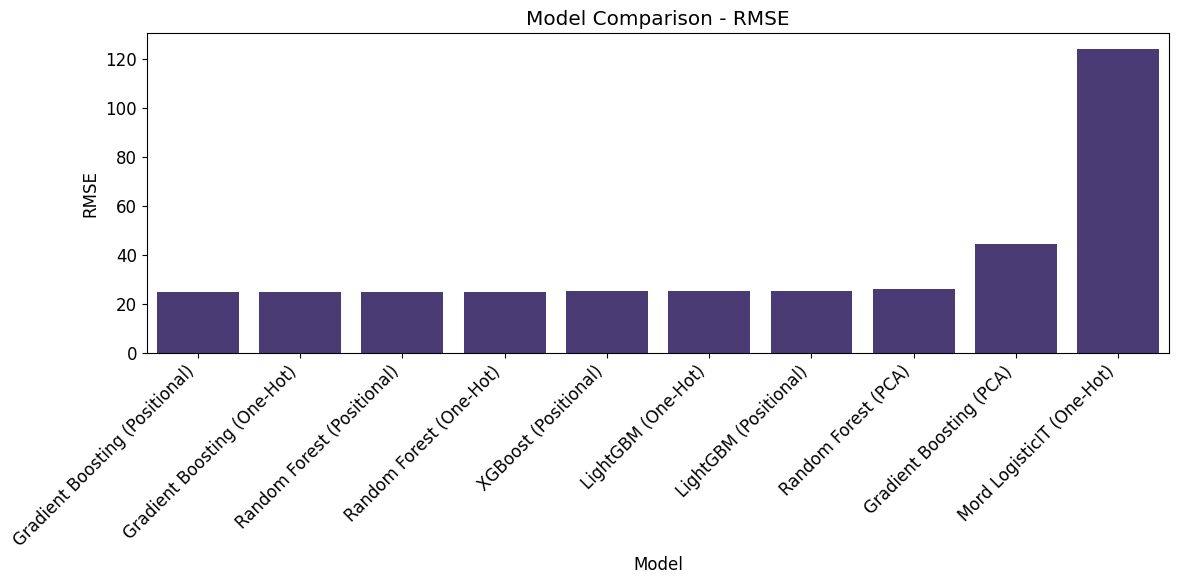

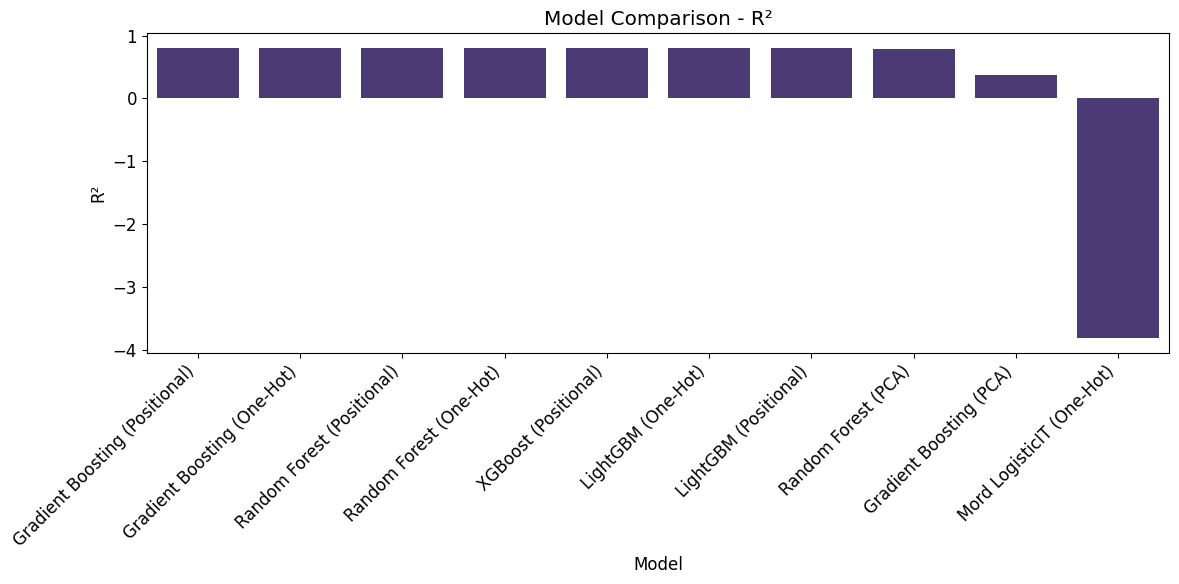

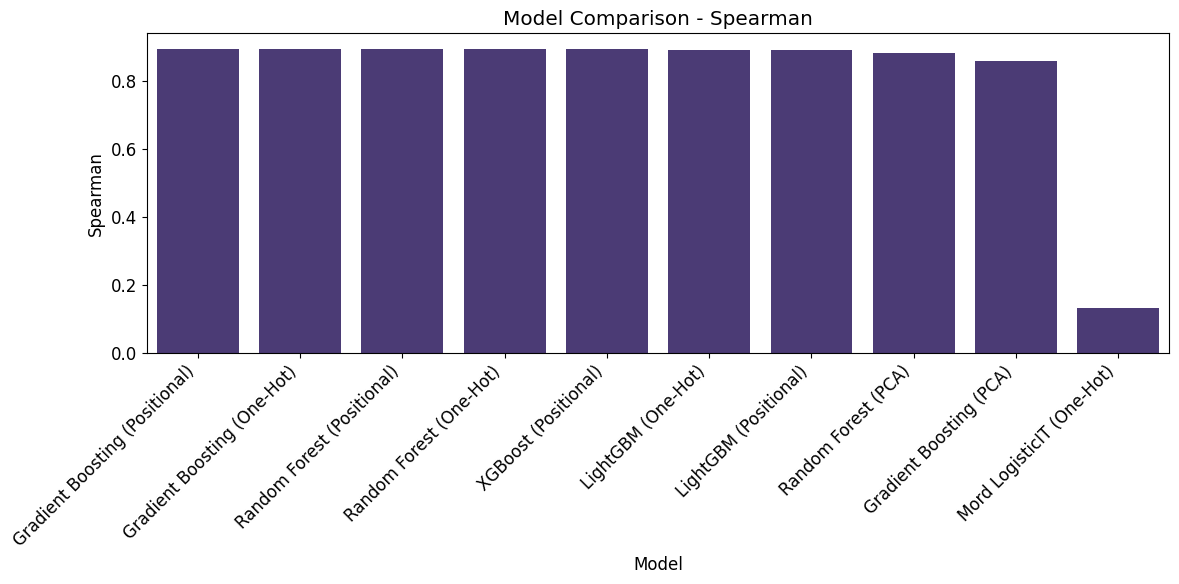

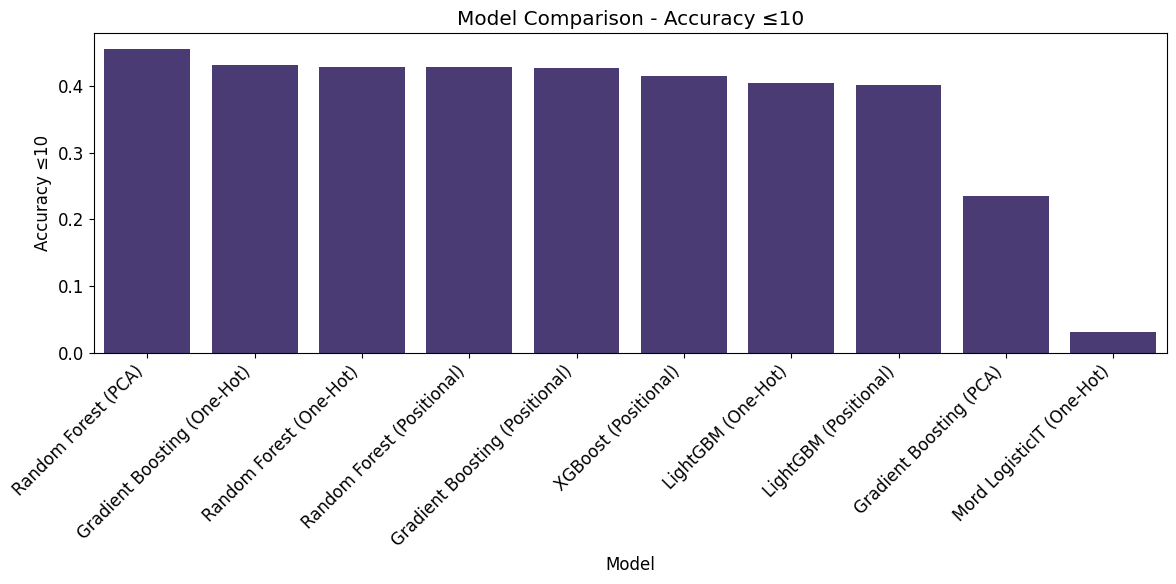

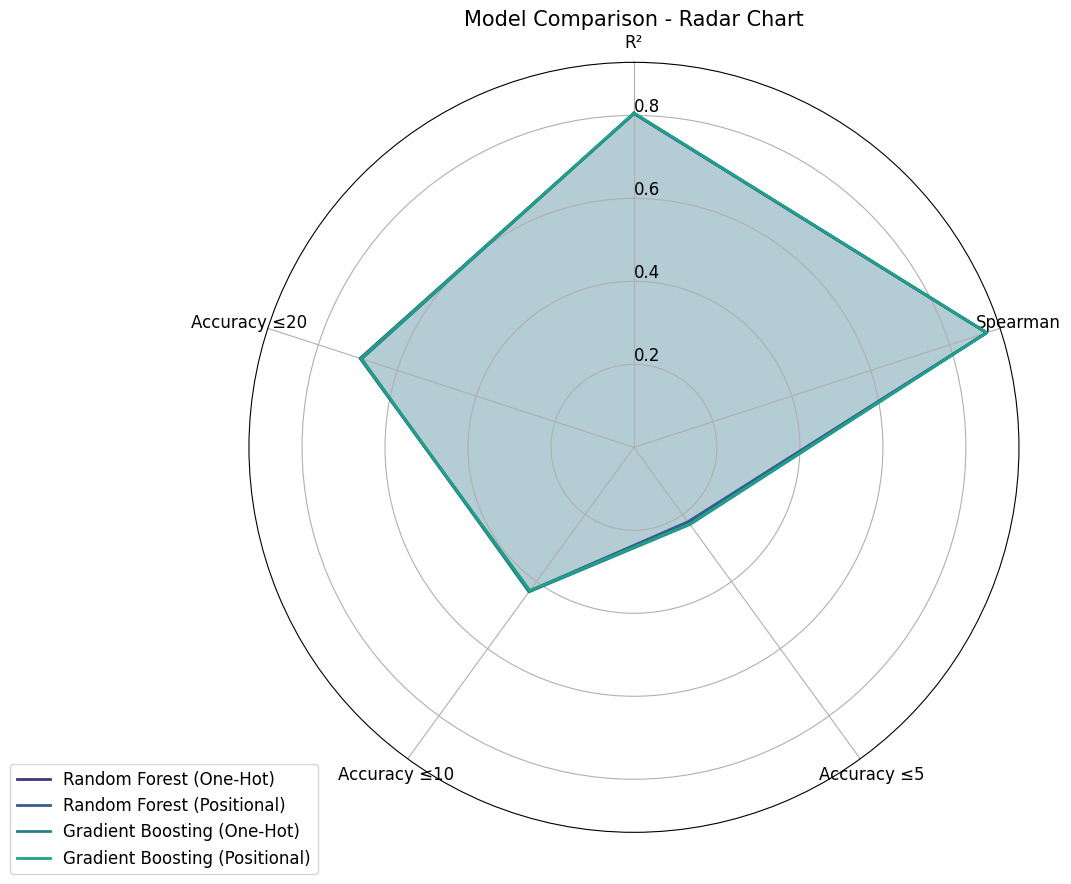


Best model based on MAE: Random Forest (One-Hot)
MAE: 17.45


In [110]:
# Compare all models
comparison_df = compare_models(model_results)

# Find the best model name
best_model_name = comparison_df.iloc[0]['Model']

# Get the best model object
best_model = model_results[best_model_name]['model']


 ## 9. Feature Importance Analysis

In [97]:
def analyze_feature_importance(model, feature_names, top_n=30):
    """
    Analyze and visualize feature importance
    
    Args:
        model: Trained model
        feature_names: List of feature names
        top_n: Number of top features to show
    """
    # Check if the model has feature_importances_ attribute
    if not hasattr(model, 'feature_importances_'):
        print("Model doesn't provide feature importances directly")
        
        # Check if it's a mord model
        if 'mord' in str(type(model)):
            print("Analyzing coefficients for Mord model...")
            if hasattr(model, 'coef_'):
                # Get coefficients
                coef = model.coef_.ravel()
                
                # Create feature importance DataFrame
                importance_df = pd.DataFrame({
                    'Feature': feature_names,
                    'Importance': np.abs(coef)  # Use absolute value for importance
                }).sort_values('Importance', ascending=False)
                
                # Plot top N features
                plt.figure(figsize=(12, 8))
                sns.barplot(x='Importance', y='Feature', data=importance_df.head(top_n))
                plt.title(f'Top {top_n} Features by Importance (Coefficient Magnitude)')
                plt.xlabel('Importance (|Coefficient|)')
                plt.tight_layout()
                plt.show()
                
                return importance_df
        
        print("Cannot analyze feature importance for this model type")
        return None
    
    # Get feature importance
    importance = model.feature_importances_
    
    # Create a DataFrame for better visualization
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values('Importance', ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(top_n))
    plt.title(f'Top {top_n} Features by Importance')
    plt.tight_layout()
    plt.show()
    
    # Extract driver-specific insights if possible
    try:
        # Try to extract driver information from feature names
        pattern = r'(Factor\d+)_Position'
        
        # Find all features matching the pattern
        factor_features = [f for f in feature_names if re.search(pattern, f)]
        
        if factor_features:
            # Extract factor importances
            factor_importance = {}
            
            for feature in factor_features:
                match = re.search(pattern, feature)
                if match:
                    factor = match.group(1)
                    idx = feature_names.index(feature)
                    
                    # Add importance to this factor
                    if factor in factor_importance:
                        factor_importance[factor] += importance[idx]
                    else:
                        factor_importance[factor] = importance[idx]
            
            # Create DataFrame and sort
            factor_df = pd.DataFrame({
                'Factor': list(factor_importance.keys()),
                'Importance': list(factor_importance.values())
            }).sort_values('Importance', ascending=False)
            
            # Plot factor importance
            plt.figure(figsize=(12, 6))
            sns.barplot(x='Importance', y='Factor', data=factor_df)
            plt.title('Overall Factor Importance')
            plt.tight_layout()
            plt.show()
            
            return importance_df, factor_df
    except Exception as e:
        print(f"Could not extract factor-specific importances: {e}")
    
    return importance_df


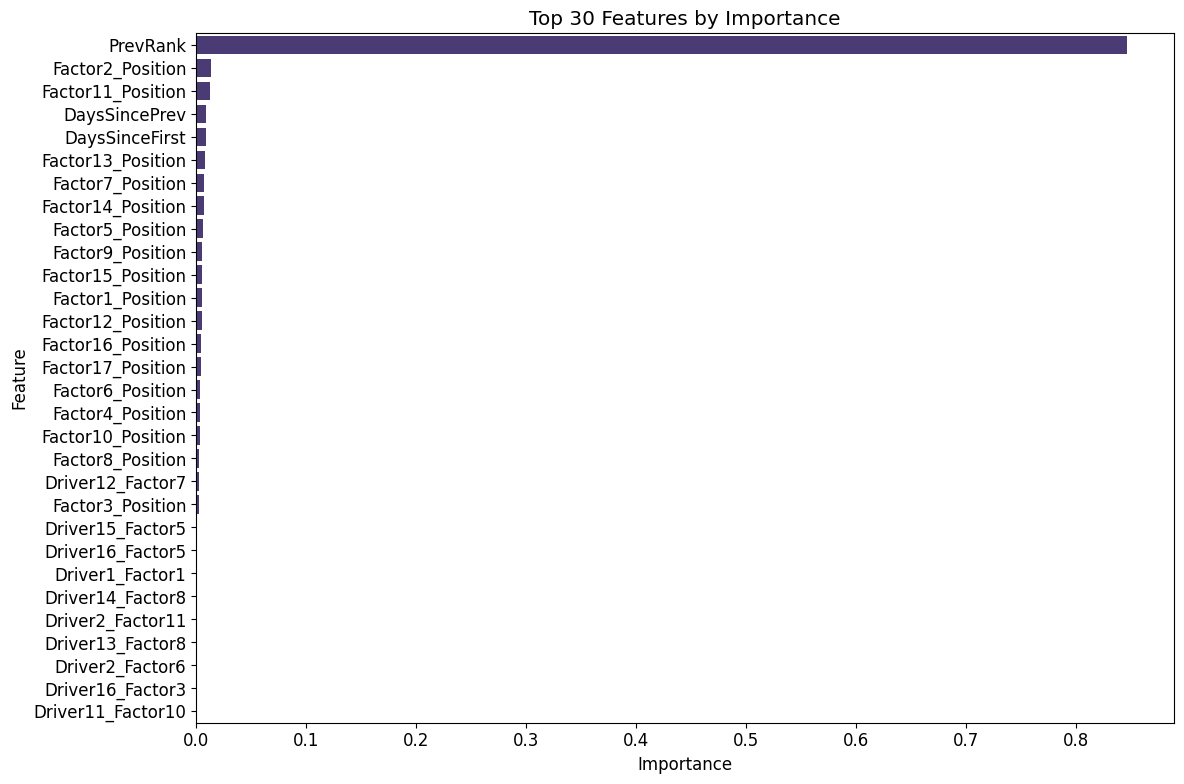

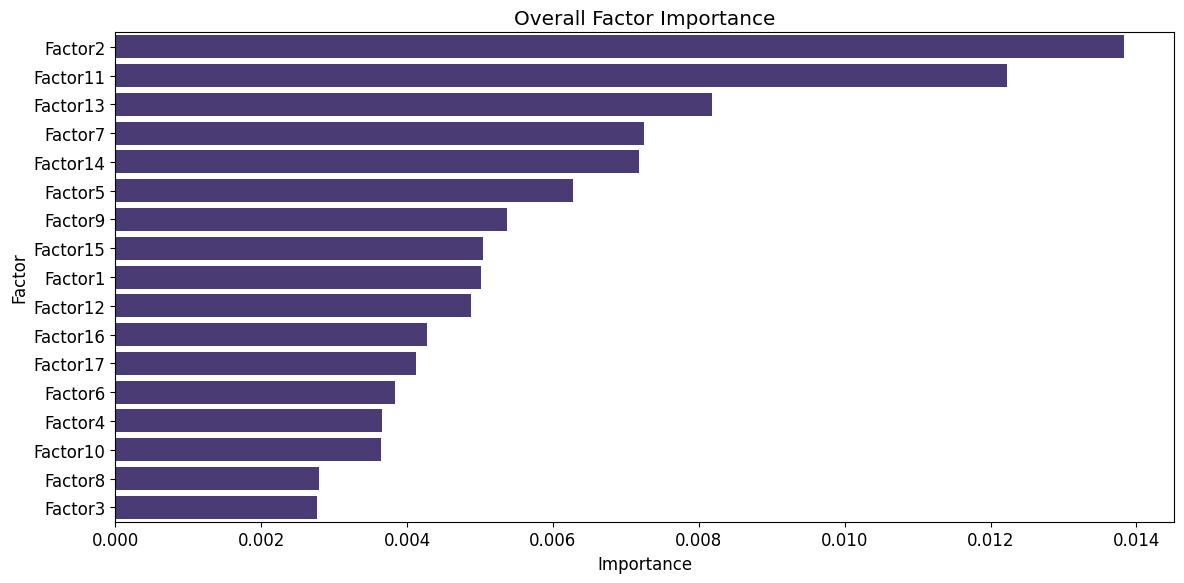

In [98]:
# Analyze feature importance for the best model
if best_model_name.startswith("Random Forest"):
    # Get corresponding feature columns based on the model type
    if "One-Hot" in best_model_name:
        importance_results = analyze_feature_importance(best_model, feature_cols_onehot)
    elif "PCA" in best_model_name:
        importance_results = analyze_feature_importance(best_model, feature_cols_pca)
    else:  # Positional
        importance_results = analyze_feature_importance(best_model, feature_cols_pos)
elif best_model_name.startswith("Mord"):
    importance_results = analyze_feature_importance(best_model, feature_cols_onehot)
else:
    # For other model types, use the appropriate feature columns
    if "One-Hot" in best_model_name:
        importance_results = analyze_feature_importance(best_model, feature_cols_onehot)
    elif "PCA" in best_model_name:
        importance_results = analyze_feature_importance(best_model, feature_cols_pca)
    else:  # Positional
        importance_results = analyze_feature_importance(best_model, feature_cols_pos)


 ## 10. Making Predictions for Future Data

In [46]:
def forecast_ranks(model, df, subject_ids=None, n_periods=3, features_type='positional'):
    """
    Forecast future ranks for selected subjects
    
    Args:
        model: Trained model
        df: Original DataFrame
        subject_ids: List of subject IDs to forecast (None for all)
        n_periods: Number of periods to forecast ahead
        features_type: Type of features to use ('positional', 'onehot', 'pca')
        
    Returns:
        DataFrame with forecasted ranks
    """
    print(f"\nForecasting {n_periods} periods ahead...")
    
    # Get the latest data for each subject
    df_sorted = df.sort_values(['SubjectID', 'UpdateDT'])
    latest_data = df_sorted.groupby('SubjectID').last().reset_index()
    
    # Filter for specific subjects if provided
    if subject_ids is not None:
        latest_data = latest_data[latest_data['SubjectID'].isin(subject_ids)]
        print(f"Forecasting for {len(latest_data)} specified subjects")
    else:
        print(f"Forecasting for all {len(latest_data)} subjects")
    
    # Generate features based on the requested type
    if features_type == 'positional':
        forecast_df, _, _, _ = engineer_features(latest_data)
    elif features_type == 'onehot':
        _, _, forecast_df, _ = engineer_features(latest_data)
    elif features_type == 'pca':
        forecast_df, _, _, pca_model = engineer_features(latest_data, dimension_reduction='pca', n_components=50)
    else:
        raise ValueError(f"Unknown features type: {features_type}")
    
    # Prepare for forecasting
    forecasts = []
    
    # For each subject, forecast multiple periods ahead
    for _, subject_data in latest_data.iterrows():
        subject_id = subject_data['SubjectID']
        last_update = subject_data['UpdateDT']
        last_rank = subject_data['Rank']
        
        # Create a copy for forecasting
        subject_forecast = subject_data.copy()
        
        # Store the initial information
        forecasts.append({
            'SubjectID': subject_id,
            'ForecastPeriod': 0,
            'ForecastDate': last_update,
            'Rank': last_rank,
            'IsForecasted': False
        })
        
        # For each forecast period
        for period in range(1, n_periods + 1):
            # Update date for this period
            new_date = last_update + pd.Timedelta(days=30 * period)  # Assuming monthly updates
            
            # Update the subject data
            subject_forecast['UpdateDT'] = new_date
            
            # Re-engineer features based on the new date
            if features_type == 'positional':
                forecast_features, _, _, _ = engineer_features(pd.DataFrame([subject_forecast]))
            elif features_type == 'onehot':
                _, _, forecast_features, _ = engineer_features(pd.DataFrame([subject_forecast]))
            elif features_type == 'pca':
                forecast_features, _, _, _ = engineer_features(
                    pd.DataFrame([subject_forecast]), 
                    dimension_reduction='pca',
                    n_components=50
                )
            
            # Exclude non-feature columns
            exclude_cols = ['SubjectID', 'Rank', 'UpdateDT', 'RankChange']
            feature_cols = [col for col in forecast_features.columns if col not in exclude_cols]
            
            # Make prediction
            X_forecast = forecast_features[feature_cols]
            
            # Scale features if needed
            if features_type == 'positional':
                numeric_cols = X_forecast.select_dtypes(include=['int64', 'float64']).columns.tolist()
                X_forecast[numeric_cols] = scaler_pos.transform(X_forecast[numeric_cols])
            elif features_type == 'onehot':
                numeric_cols = X_forecast.select_dtypes(include=['int64', 'float64']).columns.tolist()
                X_forecast[numeric_cols] = scaler_onehot.transform(X_forecast[numeric_cols])
            elif features_type == 'pca':
                numeric_cols = X_forecast.select_dtypes(include=['int64', 'float64']).columns.tolist()
                X_forecast[numeric_cols] = scaler_pca.transform(X_forecast[numeric_cols])
            
            # Handle mord models specially
            if 'mord' in str(type(model)):
                # Make prediction
                encoder = model_results["Mord LogisticIT (One-Hot)"].get('label_encoder')
                if encoder:
                    y_pred_encoded = model.predict(X_forecast)
                    predicted_rank = encoder.inverse_transform(y_pred_encoded)[0]
                else:
                    predicted_rank = model.predict(X_forecast)[0]
            else:
                # Standard prediction
                predicted_rank = model.predict(X_forecast)[0]
            
            # Round to nearest integer
            predicted_rank = round(predicted_rank)
            
            # Store forecast
            forecasts.append({
                'SubjectID': subject_id,
                'ForecastPeriod': period,
                'ForecastDate': new_date,
                'Rank': predicted_rank,
                'IsForecasted': True
            })
            
            # Update subject data for next period
            subject_forecast['Rank'] = predicted_rank
            subject_forecast['PrevRank'] = predicted_rank
            
            # If we have RankChange column, update it
            if 'RankChange' in subject_forecast:
                subject_forecast['RankChange'] = 0  # Reset for next prediction
    
    # Convert to DataFrame
    forecast_results = pd.DataFrame(forecasts)
    
    # Plot forecasts for a few selected subjects
    if subject_ids is None and len(latest_data) > 10:
        # Select a sample of subjects for visualization
        sample_subjects = latest_data['SubjectID'].sample(min(5, len(latest_data))).tolist()
    else:
        # Use all specified subjects
        sample_subjects = latest_data['SubjectID'].tolist()
    
    plt.figure(figsize=(12, 8))
    
    for subject_id in sample_subjects:
        subject_forecasts = forecast_results[forecast_results['SubjectID'] == subject_id]
        plt.plot(
            subject_forecasts['ForecastPeriod'], 
            subject_forecasts['Rank'], 
            marker='o', 
            linewidth=2, 
            label=f'Subject {subject_id}'
        )
    
    plt.xlabel('Forecast Period')
    plt.ylabel('Rank')
    plt.title('Forecasted Ranks by Period')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return forecast_results


In [ ]:
# Forecast ranks for a sample of subjects
sample_subjects = df['SubjectID'].drop_duplicates().sample(5).tolist()

# Use the best model for forecasting
forecast_results = forecast_ranks(
    best_model,
    df,
    subject_ids=sample_subjects,
    n_periods=6,
    features_type='positional' if 'Positional' in best_model_name else 'onehot'
)

# Print forecast summary
print("\nForecast Summary:")
print(forecast_results.head(20))

# Calculate rank changes between periods
forecast_results['RankChange'] = forecast_results.groupby('SubjectID')['Rank'].diff()

# Summarize rank changes
rank_change_summary = forecast_results[forecast_results['IsForecasted']].groupby('SubjectID').agg(
    InitialRank=('Rank', 'first'),
    FinalRank=('Rank', 'last'),
    TotalChange=('RankChange', 'sum'),
    AbsChange=('RankChange', lambda x: abs(x).sum()),
    AvgChange=('RankChange', 'mean')
).reset_index()

print("\nRank Change Summary:")
print(rank_change_summary)


 ## 11. Saving and Loading the Model

In [99]:
import pickle

def save_model(model, model_name, additional_data=None):
    """
    Save a trained model and associated data
    
    Args:
        model: The trained model to save
        model_name: Name to use for the saved file
        additional_data: Dictionary of additional data to save
    """
    print(f"Saving model to {model_name}.pkl...")
    
    # Create a dictionary with the model and additional data
    save_data = {
        'model': model,
        'model_name': model_name,
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }
    
    # Add any additional data
    if additional_data:
        save_data.update(additional_data)
    
    # Save to file
    with open(f"{model_name}.pkl", 'wb') as f:
        pickle.dump(save_data, f)
    
    print("Model saved successfully")

def load_model(model_name):
    """
    Load a saved model and associated data
    
    Args:
        model_name: Name of the saved model file
        
    Returns:
        Dictionary with model and associated data
    """
    print(f"Loading model from {model_name}.pkl...")
    
    # Load from file
    with open(f"{model_name}.pkl", 'rb') as f:
        save_data = pickle.load(f)
    
    print(f"Model '{save_data['model_name']}' loaded successfully")
    print(f"Saved on: {save_data['timestamp']}")
    
    return save_data


In [100]:
# Save the best model
# Include additional relevant data for future predictions
save_model(
    best_model,
    'best_rank_prediction_model',
    additional_data={
        'scaler': scaler_pos if 'Positional' in best_model_name else scaler_onehot,
        'feature_cols': feature_cols_pos if 'Positional' in best_model_name else feature_cols_onehot,
        'label_encoder': model_results[best_model_name].get('label_encoder'),
        'metrics': {k: v for k, v in model_results[best_model_name].items() if k != 'model'},
        'features_type': 'positional' if 'Positional' in best_model_name else 'onehot'
    }
)


Saving model to best_rank_prediction_model.pkl...
Model saved successfully


In [111]:
# Save all trained models
for model_name, model_data in model_results.items():
    # Get the model object
    model = model_data['model']
    
    # Determine the feature type and appropriate scaler/features
    if 'Positional' in model_name:
        scaler = scaler_pos
        feature_cols = feature_cols_pos
        features_type = 'positional'
    elif 'PCA' in model_name:
        scaler = scaler_pca
        feature_cols = feature_cols_pca
        features_type = 'pca'
    else:  # One-Hot
        scaler = scaler_onehot
        feature_cols = feature_cols_onehot
        features_type = 'onehot'
    
    # Create a filename from the model name
    filename = model_name.lower().replace(' ', '_').replace('(', '').replace(')', '')
    
    # Save the model
    save_model(
        model,
        filename,
        additional_data={
            'scaler': scaler,
            'feature_cols': feature_cols,
            'label_encoder': model_data.get('label_encoder'),
            'metrics': {k: v for k, v in model_data.items() if k != 'model'},
            'features_type': features_type,
            'is_best_model': (model_name == best_model_name)
        }
    )
    
    print(f"Saved model: {filename}")

# Also save a reference file that lists all models and their performance
model_summary = pd.DataFrame([
    {
        'model_name': name,
        'filename': name.lower().replace(' ', '_').replace('(', '').replace(')', '') + '.pkl',
        'mae': data['mae'],
        'rmse': data['rmse'],
        'r2': data['r2'],
        'spearman': data['spearman'],
        'kendall': data['kendall'],
        'accuracy_5': data['accuracy_5'],
        'accuracy_10': data['accuracy_10'],
        'accuracy_20': data['accuracy_20'],
        'is_best_model': (name == best_model_name)
    }
    for name, data in model_results.items()
]).sort_values('mae')

# Save the summary to CSV
model_summary.to_csv('model_summary.csv', index=False)
print("Saved model summary to model_summary.csv")

Saving model to random_forest_positional.pkl...
Model saved successfully
Saved model: random_forest_positional
Saving model to gradient_boosting_positional.pkl...
Model saved successfully
Saved model: gradient_boosting_positional
Saving model to lightgbm_positional.pkl...
Model saved successfully
Saved model: lightgbm_positional
Saving model to xgboost_positional.pkl...
Model saved successfully
Saved model: xgboost_positional
Saving model to random_forest_one-hot.pkl...
Model saved successfully
Saved model: random_forest_one-hot
Saving model to gradient_boosting_one-hot.pkl...
Model saved successfully
Saved model: gradient_boosting_one-hot
Saving model to lightgbm_one-hot.pkl...
Model saved successfully
Saved model: lightgbm_one-hot
Saving model to random_forest_pca.pkl...
Model saved successfully
Saved model: random_forest_pca
Saving model to gradient_boosting_pca.pkl...
Model saved successfully
Saved model: gradient_boosting_pca
Saving model to mord_logisticit_one-hot.pkl...
Model sa

 Let's verify we can load the model and use it for predictions

In [ ]:
# Load the model
loaded_data = load_model('best_rank_prediction_model')

# Extract components
loaded_model = loaded_data['model']
loaded_scaler = loaded_data['scaler']
loaded_features_type = loaded_data['features_type']

# Make a test prediction
test_forecast = forecast_ranks(
    loaded_model,
    df,
    subject_ids=sample_subjects[:2],  # Just use 2 subjects for testing
    n_periods=3,
    features_type=loaded_features_type
)

print("Test prediction successful!")


In [114]:
# Save the original dataset
df.to_csv('original_dataset.csv', index=False)
print("Saved original dataset to original_dataset.csv")

# Save the positional features dataset
df_positional.to_csv('positional_features.csv', index=False)
print("Saved positional features dataset to positional_features.csv")

# Save the one-hot encoded features dataset
df_onehot.to_csv('onehot_features.csv', index=False)
print("Saved one-hot encoded features dataset to onehot_features.csv")

# If PCA features were created, save those too
if 'df_pca' in locals() or 'df_pca' in globals():
    df_pca.to_csv('pca_features.csv', index=False)
    print("Saved PCA features dataset to pca_features.csv")
    
    # If you want to save the PCA model itself for future transformations
    import joblib
    joblib.dump(pca_model, 'pca_model.pkl')
    print("Saved PCA model to pca_model.pkl")

Saved original dataset to original_dataset.csv
Saved positional features dataset to positional_features.csv
Saved one-hot encoded features dataset to onehot_features.csv
Saved PCA features dataset to pca_features.csv
Saved PCA model to pca_model.pkl


In [115]:
# Save train-test datasets
X_train_pos.to_csv('X_train_positional.csv', index=False)
X_test_pos.to_csv('X_test_positional.csv', index=False)
print("Saved positional train-test datasets")

X_train_onehot.to_csv('X_train_onehot.csv', index=False)
X_test_onehot.to_csv('X_test_onehot.csv', index=False)
print("Saved one-hot train-test datasets")

if 'X_train_pca' in locals() or 'X_train_pca' in globals():
    X_train_pca.to_csv('X_train_pca.csv', index=False)
    X_test_pca.to_csv('X_test_pca.csv', index=False)
    print("Saved PCA train-test datasets")

# Save target variable
pd.DataFrame({'y_train': y_train}).to_csv('y_train.csv', index=False)
pd.DataFrame({'y_test': y_test}).to_csv('y_test.csv', index=False)
print("Saved target variables")

# Save feature column lists for future reference
with open('feature_columns.pkl', 'wb') as f:
    pickle.dump({
        'feature_cols_pos': feature_cols_pos,
        'feature_cols_onehot': feature_cols_onehot,
        'feature_cols_pca': feature_cols_pca if 'feature_cols_pca' in locals() or 'feature_cols_pca' in globals() else None
    }, f)
print("Saved feature column lists")

Saved positional train-test datasets
Saved one-hot train-test datasets
Saved PCA train-test datasets
Saved target variables
Saved feature column lists


 ## 12. Summary of Findings

In [113]:
# Create a summary of our findings
print("="*80)
print("SUMMARY OF FINDINGS")
print("="*80)

# Best model
print("\nBest Model:")
print(f"- {best_model_name} with MAE: {model_results[best_model_name]['mae']:.2f}")
print(f"- R²: {model_results[best_model_name]['r2']:.4f}")
print(f"- Spearman Correlation: {model_results[best_model_name]['spearman']:.4f}")
print(f"- Accuracy within 10 ranks: {model_results[best_model_name]['accuracy_10']:.2%}")

# Important feature insights
print("\nKey Findings on Drivers:")
try:
    # Extract factor importance if available
    if isinstance(importance_results, tuple) and len(importance_results) == 2:
        importance_df, factor_df = importance_results
        for factor, importance in factor_df.head(5).values:
            print(f"- {factor} has significant impact on rank (Importance: {importance:.4f})")
    elif isinstance(importance_results, pd.DataFrame):
        # Check if we have positional features
        pos_features = [f for f in importance_results['Feature'][:10] if '_Position' in f]
        if pos_features:
            for feature in pos_features:
                idx = importance_results['Feature'].tolist().index(feature)
                importance = importance_results['Importance'].iloc[idx]
                print(f"- {feature} influences rank (Importance: {importance:.4f})")
except:
    print("- Feature importance analysis not available for the best model")

# Driver importance from initial analysis
print("\nDriver Importance Analysis:")
for i, (driver, std_dev) in enumerate(driver_importance[['Driver', 'RankStdDev']].head(5).values):
    print(f"- {driver} has {std_dev:.2f} standard deviation in rank (#{i+1} most influential)")

# Forecasting insights
# print("\nForecasting Insights:")
# print(f"- Forecasted {n_periods} periods ahead for {len(sample_subjects)} sample subjects")
# print(f"- Average absolute rank change per subject: {rank_change_summary['AbsChange'].mean():.2f}")
# print(f"- Largest absolute rank change: {rank_change_summary['AbsChange'].max():.2f}")

print("\nAnalysis complete.")


SUMMARY OF FINDINGS

Best Model:
- Random Forest (One-Hot) with MAE: 17.45
- R²: 0.8046
- Spearman Correlation: 0.8935
- Accuracy within 10 ranks: 42.83%

Key Findings on Drivers:
- Factor2 has significant impact on rank (Importance: 0.0138)
- Factor11 has significant impact on rank (Importance: 0.0122)
- Factor13 has significant impact on rank (Importance: 0.0082)
- Factor7 has significant impact on rank (Importance: 0.0073)
- Factor14 has significant impact on rank (Importance: 0.0072)

Driver Importance Analysis:
- Driver17 has 38.75 standard deviation in rank (#1 most influential)
- Driver16 has 34.00 standard deviation in rank (#2 most influential)
- Driver15 has 29.63 standard deviation in rank (#3 most influential)
- Driver14 has 28.36 standard deviation in rank (#4 most influential)
- Driver1 has 26.75 standard deviation in rank (#5 most influential)

Analysis complete.
